
# Sector-Neutral Stock Screener with K-Means: Turn 21 Metrics into Actionable Buckets Value, Growth and more
> **Overview**  
> This end-to-end project walks through a lightweight, sector-neutral machine learning pipeline that uses K-Means to cluster S&P 500 stocks into clear factor-aware buckets such as Undervalued , High Growth and more, helping investor to get a ready-to-explore stock list instead of drowning in financial data.

> **Further Reading**  
> - For detailed methodology rationale, see [From Fundamentals to Factor Buckets](https://medium.com/@rmmrinal.q/from-data-overload-to-actionable-buckets-k-means-clustering-for-stock-screening-b1520b9c7484) on Medium.
> - GitHub repo : [Portfolio_Screener](https://github.com/rmrinalquant/Portfolio_Screener)

> **Contents**
> - Preprocessing pipeline code  
> - Cluster validation metrics  
> - Centroid values  
> - Portfolio backtest implementation

> **Prerequisites**  
> - Familiarity with factor-based investing concepts  
> - Understanding of K-Means clustering  

> **Data**  
> - Fundamental Metrics : Snapshot of key ratios (Trailing P/E, P/S, ROA,ROE, profit margin, debt/equity, etc.) as of April 22 2025.
> - Technical Data : Historic data of daily price since Apr 17 2017.
> - Risk Return Metrics : Precomputed data of metrics like annualized return, volatility, Sharpe Ratio, Beta and Max Drawdown, for period ( 16 Apr 2022 to 22 Apr 2025) — three years.
> - Notebook covers each data points in detail - check below - also  I have uploaded CSV file for quick run and experimentation - Data credit to Yahoo Finance. For custom data please use official yfinace library to get data

> **Author:** @mrinalquant | **Updated:** 23 Jun 2025 |  **If this helped, please up-vote!**”

In [1]:
# Importing basic data processing libraries 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
import yfinance as yf
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [ ]:
# Setting path to fetch data 
base_dir = os.path.abspath(os.path.join(os.getcwd(),".."))
path = os.path.join(base_dir,'artifacts')

# 1 : Data Overview – What’s Inside the Snapshot?

Before we model anything, we need to understand the raw material.  
In this section we will:

1. **Describe each table** – fundamentals and risk/return metrics.  
2. **Check completeness** – highlight missing-value pockets.  
3. **Explore distributions** – plot key ratios (e.g., P/E, ROA) to reveal skewness and outliers.
4. **Spot sector bias** – compare metrics like ROA across Tech vs Utilities to show why a sector-neutral scale is essential.  

By the end of this section you should have a clear picture of **what the data looks like, where it’s messy.**


## 1.1. Describe Table and Distributions

In [ ]:
# Load the files
fundamentals_df = pd.read_csv(f'{path}/fundamental.csv')
risk_df = pd.read_csv(f'{path}'/'technical.csv')
sp500_df = pd.read_csv(f'{path}'/'metadata.csv')

# Display first few rows
print("Fundamentals Data Preview:")
display(fundamentals_df.head())

print("\nRisk-Return Data Preview:")
#display(risk_df.head())

print("\nS&P 500 List Preview:")
#display(sp500_df.head())


Fundamentals Data Preview:


stock_id  trailing_pe  forward_pe  price_to_book  price_to_sales  \
0    910000    18.687326   17.173418      19.049423        3.074677   
1    910001    17.365013   15.487715       4.829898        2.424506   
2    910002    17.209423   25.480620       4.776922        5.430350   
3    910003    72.801470   14.284213      91.967890        5.531372   
4    910004    23.351484   20.115139       6.062202        2.665183   

   peg_ratio  profit_margin  return_on_equity  return_on_assets  \
0        NaN        0.16981           0.91851           0.05929   
1        NaN        0.13976           0.28627           0.13533   
2        NaN        0.31886               NaN               NaN   
3        NaN        0.07594           0.62292           0.08491   
4        NaN        0.11430           0.26965           0.11576   

   revenue_growth  eps_growth  dividend_yield  debt_to_equity  current_ratio  \
0           0.001      -0.230        0.028630         350.770          1.411   
1          -0.077      -0.201        0.021066          12.132          1.552   
2           0.040       0.082        0.017553          31.889            NaN   
3           0.056         NaN        0.036965        2021.968          0.660   
4           0.054       0.068        0.020521          26.706          1.477   

     market_cap  operating_cash_flow  free_cash_flow  created_at  
0  7.556018e+10         1.819000e+09    1.678875e+09  2025-04-22  
1  9.257005e+09         5.818000e+08    3.900000e+08  2025-04-22  
2  2.299427e+11                  NaN             NaN  2025-04-22  
3  3.116043e+11         1.880600e+10    1.997750e+10  2025-04-22  
4  1.791576e+11         1.040732e+10    8.601245e+09  2025-04-22


Risk-Return Data Preview:

S&P 500 List Preview:


In [4]:
# Re-merge fundamentals and risk/return data on 'stock_id'
merged_df = pd.merge(fundamentals_df, risk_df, on='stock_id', how='inner')
merged_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

stock_id  trailing_pe  forward_pe  price_to_book  price_to_sales  \
0    910000    18.687326   17.173418      19.049423        3.074677   
1    910001    17.365013   15.487715       4.829898        2.424506   
2    910002    17.209423   25.480620       4.776922        5.430350   
3    910003    72.801470   14.284213      91.967890        5.531372   
4    910004    23.351484   20.115139       6.062202        2.665183   

   peg_ratio  profit_margin  return_on_equity  return_on_assets  \
0        NaN        0.16981           0.91851           0.05929   
1        NaN        0.13976           0.28627           0.13533   
2        NaN        0.31886               NaN               NaN   
3        NaN        0.07594           0.62292           0.08491   
4        NaN        0.11430           0.26965           0.11576   

   revenue_growth  ...    market_cap  operating_cash_flow  free_cash_flow  \
0           0.001  ...  7.556018e+10         1.819000e+09    1.678875e+09   
1          -0.077  ...  9.257005e+09         5.818000e+08    3.900000e+08   
2           0.040  ...  2.299427e+11                  NaN             NaN   
3           0.056  ...  3.116043e+11         1.880600e+10    1.997750e+10   
4           0.054  ...  1.791576e+11         1.040732e+10    8.601245e+09   

   created_at_x  annual_return  volatility  sharpe_ratio  beta  max_drawdown  \
0    2025-04-22           0.07        0.36          0.07  0.80         -0.40   
1    2025-04-22           0.02        0.32         -0.07  0.88         -0.34   
2    2025-04-22           0.06        0.24          0.07  0.61         -0.25   
3    2025-04-22           0.07        0.26          0.10  0.39         -0.20   
4    2025-04-22          -0.02        0.31         -0.21  1.04         -0.29   

   created_at_y  
0    2025-04-26  
1    2025-04-26  
2    2025-04-26  
3    2025-04-26  
4    2025-04-26  

[5 rows x 24 columns]

In [5]:
def check_distribution(df, columns, title="Metric Distributions", ncols=2):
    rows = (len(columns) + ncols - 1) // ncols
    fig, axes = plt.subplots(rows, ncols, figsize=(6 * ncols, 4 * rows))
    axes = axes.flatten()

    for idx, col in enumerate(columns):
        try:
            data = pd.to_numeric(df[col], errors='coerce').dropna()
            mean_val = data.mean()
            median_val = data.median()

            sns.histplot(data, kde=True, bins=40, ax=axes[idx], color='cornflowerblue')
            axes[idx].axvline(mean_val, color='orange', linestyle='--', label=f'Mean: {mean_val:.2f}')
            axes[idx].axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.2f}')
            axes[idx].set_title(f"{col} Distribution", fontsize=11, weight='bold')
            axes[idx].legend()
            axes[idx].grid(True)
        except Exception as e:
            axes[idx].set_visible(False)
            print(f" Skipped {col} due to error: {e}")

    for j in range(idx + 1, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(title, fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


### 📈 Profitability Metrics – Rationale for Selection

Profitability metrics reveal how efficiently a company converts its revenues and resources into profit. They’re essential for assessing the **financial health, operational efficiency**, and **management effectiveness** of a business.

---

### 📊 Selected Metrics and Their Purpose

- **Profit Margin**
    - *Definition:* Net Income ÷ Revenue
    - *Use:* Indicates what percentage of each dollar earned is kept as profit.
    - *Why We Use It:* Reflects a company's cost control and operational leverage. Useful for comparing companies in the same industry.
- **Return on Equity (ROE)**
    - *Definition:* Net Income ÷ Shareholders’ Equity
    - *Use:* Measures how effectively a company uses shareholders’ capital to generate profits.
    - *Why We Use It:* A high ROE is often a hallmark of shareholder-friendly companies and strong capital efficiency.
- **Return on Assets (ROA)**
    - *Definition:* Net Income ÷ Total Assets
    - *Use:* Assesses how efficiently a company uses its total assets to produce earnings.
    - *Why We Use It:* Important in capital-intensive industries; highlights operational efficiency.

---

### 👥 Why It Matters for Different Investors

- **First-Time Investors:** Often unaware of financial ratios — but can benefit from high-profit companies that reduce downside risk.
- **Retail Investors:** ROE is a favorite metric for identifying quality stocks with strong fundamentals.
- **Institutional Managers:** Use profitability metrics for screening, peer benchmarking, and ranking companies within sectors.

---

### 🧠 Key Insights

- These metrics are often **positively skewed** but less extreme than valuation metrics.
- Strong profitability is a signal of **competitive advantage** and long-term sustainability.
- In clustering, they help identify "core compounders" (companies that consistently grow profits) vs. cyclicals or turnarounds.

---

### 📚 References

- CFA Institute: *Equity Investments – Return Measures* (ROE, ROA, Margins)
- Damodaran, A. (2012). *Investment Valuation*. Wiley Finance.
- Investopedia, Morningstar, and Yahoo Finance definitions and use in screeners.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


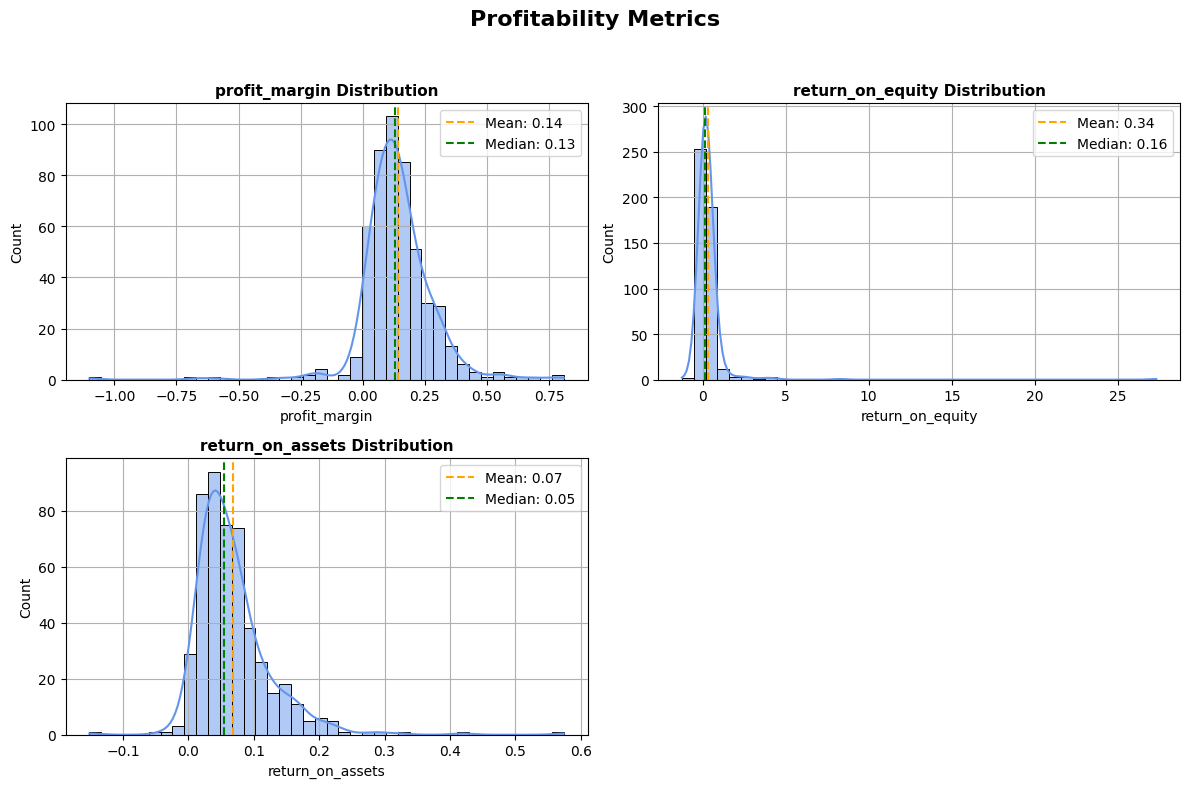

In [6]:
profitability_metrics = ['profit_margin', 'return_on_equity', 'return_on_assets']
check_distribution(fundamentals_df, profitability_metrics, title="Profitability Metrics")

### 💼 Valuation Metrics – Rationale for Selection

Valuation metrics help investors determine whether a stock is overvalued or undervalued relative to its fundamentals. These metrics are key inputs in **stock screening**, **portfolio construction**, and **investment decision-making** for nearly all investor types — from first-time retail investors to institutional portfolio managers.

---

### 📊 Selected Metrics and Their Purpose

- **Trailing P/E (Price-to-Earnings Ratio)**
    - *Definition:* Current share price divided by earnings per share (last 12 months).
    - *Use:* Helps investors understand how much they are paying for $1 of past earnings.
    - *Why We Use It:* Universally used in valuation screens; reflects actual company performance.
- **Forward P/E**
    - *Definition:* Price divided by expected earnings per share (next 12 months).
    - *Use:* Reflects market expectations about a company’s future earnings growth.
    - *Why We Use It:* Important for growth investors and market sentiment interpretation.
- **Price-to-Book (P/B) Ratio**
    - *Definition:* Price per share divided by book value per share (assets minus liabilities).
    - *Use:* Indicates how much investors are paying for the company’s net asset value.
    - *Why We Use It:* Useful for evaluating asset-heavy businesses (e.g., banks, utilities).
- **Price-to-Sales (P/S) Ratio**
    - *Definition:* Market cap divided by total revenue.
    - *Use:* Helps assess valuation independent of profitability.
    - *Why We Use It:* Important for high-growth companies with thin margins or no profit yet.

---

### 👤 Why It Matters for Different Investors

- **First-Time Investors:** Often focus on popular stocks with buzz; P/E helps prevent overpaying for hype.
- **Retail Investors:** Use P/E and P/B filters for value and quality screening.
- **Institutional Managers:** Consider sector-relative valuation and market expectations (Forward P/E and P/S).

---

### 🧠 Key Insights

- These metrics are **often skewed** due to sector differences or market cycles, but that doesn't reduce their relevance.
- Instead of dropping skewed metrics like `trailing_pe`, we apply **log-transformation** and **outlier capping** to prepare them for clustering.
- Valuation ratios are **fundamental to classifying investment styles** such as value, growth, or GARP (growth at a reasonable price).

---

### 📚 References

- Damodaran, A. (2012). *Investment Valuation*. Wiley Finance.
- CFA Institute. (2020). *Equity Investments – Valuation Ratios & Multiples*.
- Morningstar, Yahoo Finance, Investopedia definitions and screening use cases.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

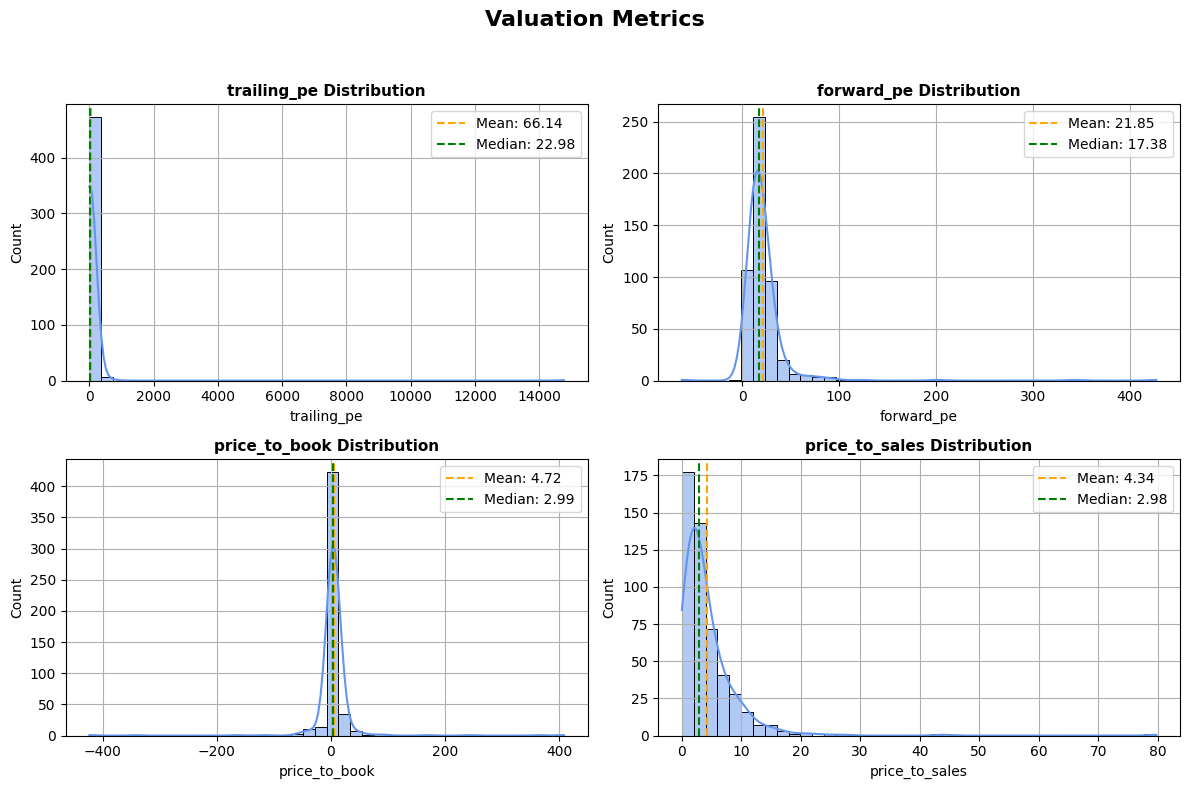

In [7]:
valuation_metrics = ['trailing_pe', 'forward_pe', 'price_to_book', 'price_to_sales']
check_distribution(fundamentals_df, valuation_metrics, title="Valuation Metrics")

### 📈 Growth Metrics – Rationale for Selection

Growth metrics capture a company’s ability to expand its business, revenues, and earnings over time. These indicators are especially important to **growth investors**, **early-stage opportunity seekers**, and **portfolio managers** looking for capital appreciation.

---

### 📊 Selected Metrics and Their Purpose

- **Revenue Growth**
    - *Definition:* Year-over-year percentage change in total revenue.
    - *Use:* Measures the expansion in a company’s sales.
    - *Why We Use It:* It's a foundational indicator of business momentum and product-market fit.
- **EPS Growth (Earnings Per Share Growth)**
    - *Definition:* Percentage increase in earnings per share over time.
    - *Use:* Evaluates profit growth on a per-share basis, accounting for stock buybacks or dilution.
    - *Why We Use It:* EPS is often used by analysts and investors to assess the earnings trajectory, which drives stock price performance.

---

### 👥 Why It Matters for Different Investors

- **First-Time Investors:** May be drawn to fast-growing brands or "story stocks" with high revenue spikes.
- **Retail Investors:** Often use EPS growth in screeners to find outperformers.
- **Institutional Managers:** Look at both revenue and EPS growth in relative terms (vs. sector/benchmark) to spot long-term trends.

---

### 🧠 Key Insights from EDA

- `revenue_growth` is **mildly right-skewed**, mostly centered around 5–7%, with a few high-growth outliers.
- `eps_growth` is **highly right-skewed**, with extreme outliers (1000%+ EPS growth), which can distort clustering.
- These features will likely require **outlier treatment or log transformation** to prevent clustering bias.

---

### 📚 References

- CFA Institute (2020). *Equity Investments – Earnings Analysis*.
- Damodaran, A. (2012). *Investment Valuation*.
- Morningstar, Investopedia, Yahoo Finance data definitions.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


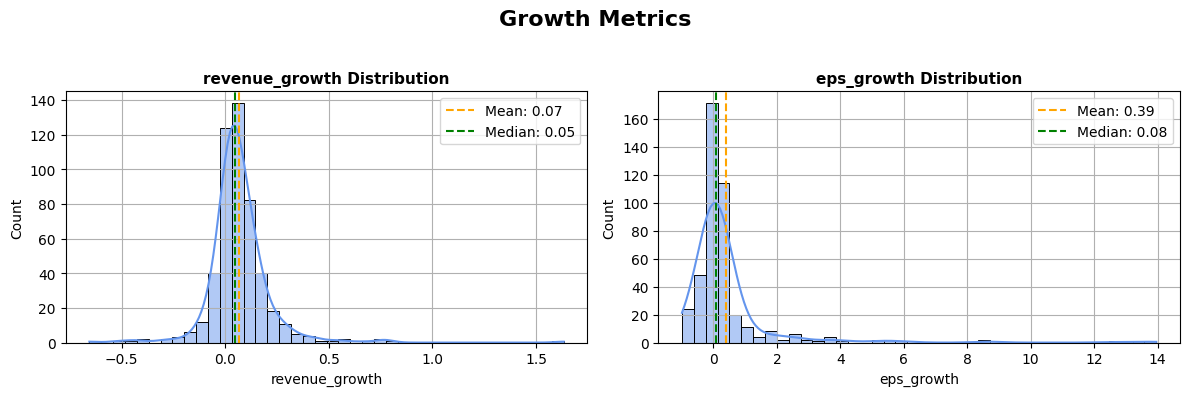

In [8]:
growth_metrics = ['revenue_growth', 'eps_growth']
check_distribution(fundamentals_df, growth_metrics, title="Growth Metrics")

### 💰 Stability & Income Metrics – Rationale for Selection

These metrics assess a company’s ability to manage its **debt obligations**, maintain **liquidity**, and **reward investors with consistent payouts**. They’re highly relevant for **income-seeking**, **risk-averse**, and **long-term conservative investors**.

---

### 📊 Selected Metrics and Their Purpose

- **Dividend Yield**
    - *Definition:* Annual dividend ÷ Share price
    - *Use:* Shows the cash return an investor receives relative to the stock price.
    - *Why We Use It:* Helps identify dividend-paying companies — crucial for income portfolios and retirement strategies.
- **Debt-to-Equity Ratio**
    - *Definition:* Total Liabilities ÷ Shareholders’ Equity
    - *Use:* Indicates how much a company is relying on debt to fund operations.
    - *Why We Use It:* High leverage can signal financial risk. Key in credit risk analysis and identifying volatile or distressed companies.
- **Current Ratio**
    - *Definition:* Current Assets ÷ Current Liabilities
    - *Use:* Measures short-term financial health and liquidity.
    - *Why We Use It:* A ratio below 1.0 indicates potential liquidity issues, while very high values may suggest poor capital deployment.

---

### 👥 Why It Matters for Different Investors

- **First-Time Investors:** May be drawn to dividend-paying stocks for passive income.
- **Retail Investors:** Use current ratio and debt-to-equity to avoid risky or over-leveraged companies.
- **Institutional Managers:** Include these metrics in screening filters and risk-weighted asset models.

---

### 🧠 Key Insights from EDA

- `dividend_yield` shows **moderate right skew**, with a clear cluster between 0–2%. Higher values (5%+) are rare and might indicate undervalued or riskier income stocks.
- `debt_to_equity` is **heavily skewed** due to extreme outliers (e.g. D/E > 8000). This requires **log transformation or outlier capping**.
- `current_ratio` has **moderate skew** and most values are healthy (>1.0). It can be retained with mild transformation or clipping.

---

### 📚 References

- CFA Institute: *Corporate Finance – Working Capital & Capital Structure*
- Damodaran, A. (2012). *Investment Valuation*
- Morningstar & Investopedia financial definitions and risk screening tools

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


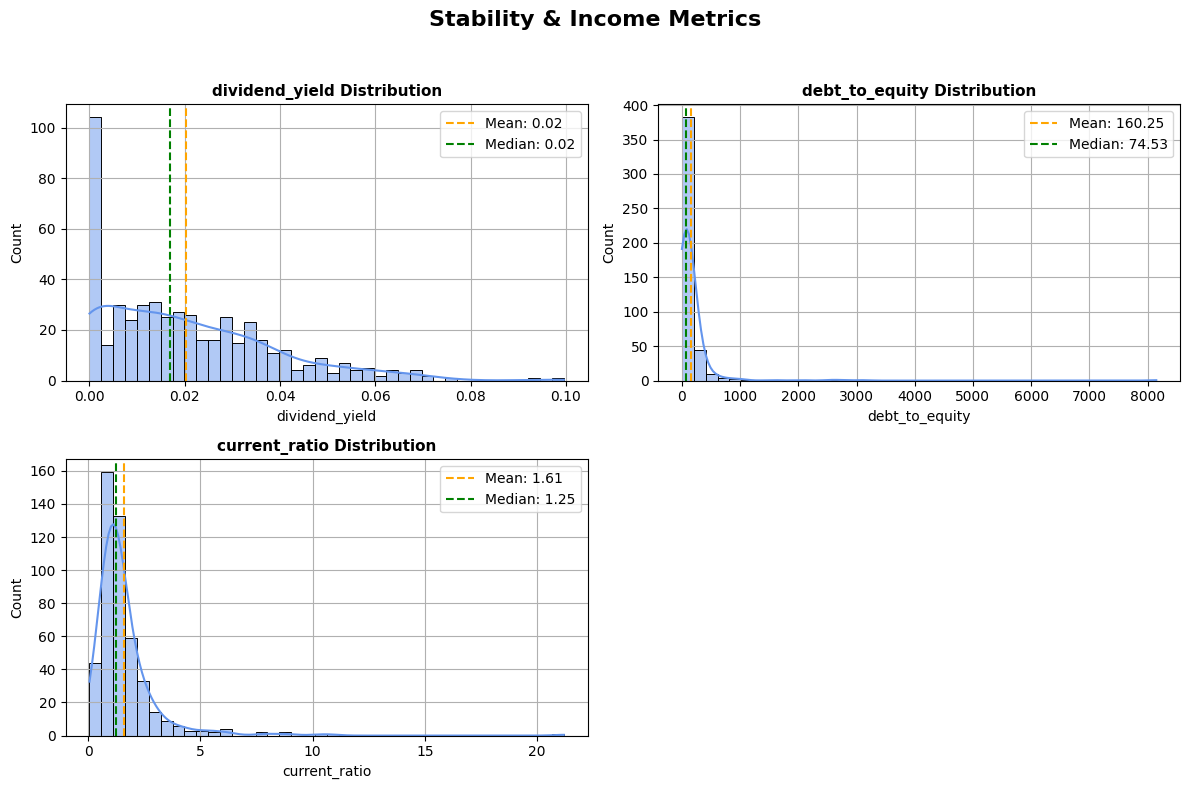

In [9]:
stability_income_metrics = ['dividend_yield', 'debt_to_equity', 'current_ratio']
check_distribution(fundamentals_df, stability_income_metrics, title="Stability & Income Metrics")

### 💸 Cash Flow & Risk/Return Metrics – Rationale for Selection

These metrics assess a company's **financial engine (cash flows)** and how well it performs in the market **relative to its risk**. They are key to evaluating both **internal financial strength** and **external investor appeal** — making them essential for portfolio construction, asset screening, and risk-adjusted performance.

---

### 📊 Selected Metrics and Their Purpose

- **Operating Cash Flow**
    - *Definition:* Cash generated from core business operations.
    - *Use:* Indicates sustainability of operations — more reliable than net income.
    - *Why We Use It:* It highlights companies with real cash-generating power.
- **Free Cash Flow**
    - *Definition:* Operating Cash Flow – Capital Expenditures
    - *Use:* Shows how much cash is truly available for dividends, buybacks, or reinvestment.
    - *Why We Use It:* Favored by value investors and fundamental analysts; reveals long-term strength.
- **Annual Return**
    - *Definition:* 1-year price return of the stock.
    - *Use:* Measures actual investor performance over a recent period.
    - *Why We Use It:* Standard for comparing stock outcomes, used in portfolio backtesting.
- **Volatility**
    - *Definition:* Standard deviation of returns (typically daily or monthly).
    - *Use:* Measures market risk — how much the stock price fluctuates.
    - *Why We Use It:* Critical for balancing risk in portfolio optimization.
- **Sharpe Ratio**
    - *Definition:* (Return – Risk-Free Rate) ÷ Volatility
    - *Use:* Assesses return per unit of risk — the go-to metric for risk-adjusted performance.
    - *Why We Use It:* Used by both retail and institutional investors in fund comparison and stock screening.
- **Beta**
    - *Definition:* Measure of stock volatility relative to the market (S&P 500).
    - *Use:* Beta > 1 = aggressive; Beta < 1 = defensive.
    - *Why We Use It:* Essential for understanding market sensitivity and building balanced portfolios.

---

### 👥 Why It Matters for Different Investors

- **First-Time Investors:** May not track cash flow deeply but rely on risk-adjusted returns to avoid unstable stocks.
- **Retail Investors:** Use volatility and Sharpe Ratio to avoid underperformers or risky bets.
- **Institutional Managers:** Optimize portfolios using metrics like Beta, Sharpe Ratio, and FCF in asset selection and risk allocation.

---

### 🧠 Key Insights from EDA

- `operating_cash_flow` and `free_cash_flow` are **heavily right-skewed** due to mega-cap firms; will need **log transformation**.
- `sharpe_ratio` is wide and includes **negatives**, suggesting underperformance is common — requires **winsorization or transformation**.
- `annual_return` and `beta` are **well-behaved** and centered
- `volatility` shows long tails — **robust scaling** might help.

---

### 📚 References

- CFA Institute (2021): *Portfolio Management and Wealth Planning – Risk & Return*
- Damodaran, A. (2012): *Investment Valuation*
- Morningstar & Investopedia metric definitions
- Black-Litterman and Sharpe (1966) – risk-adjusted return theory

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

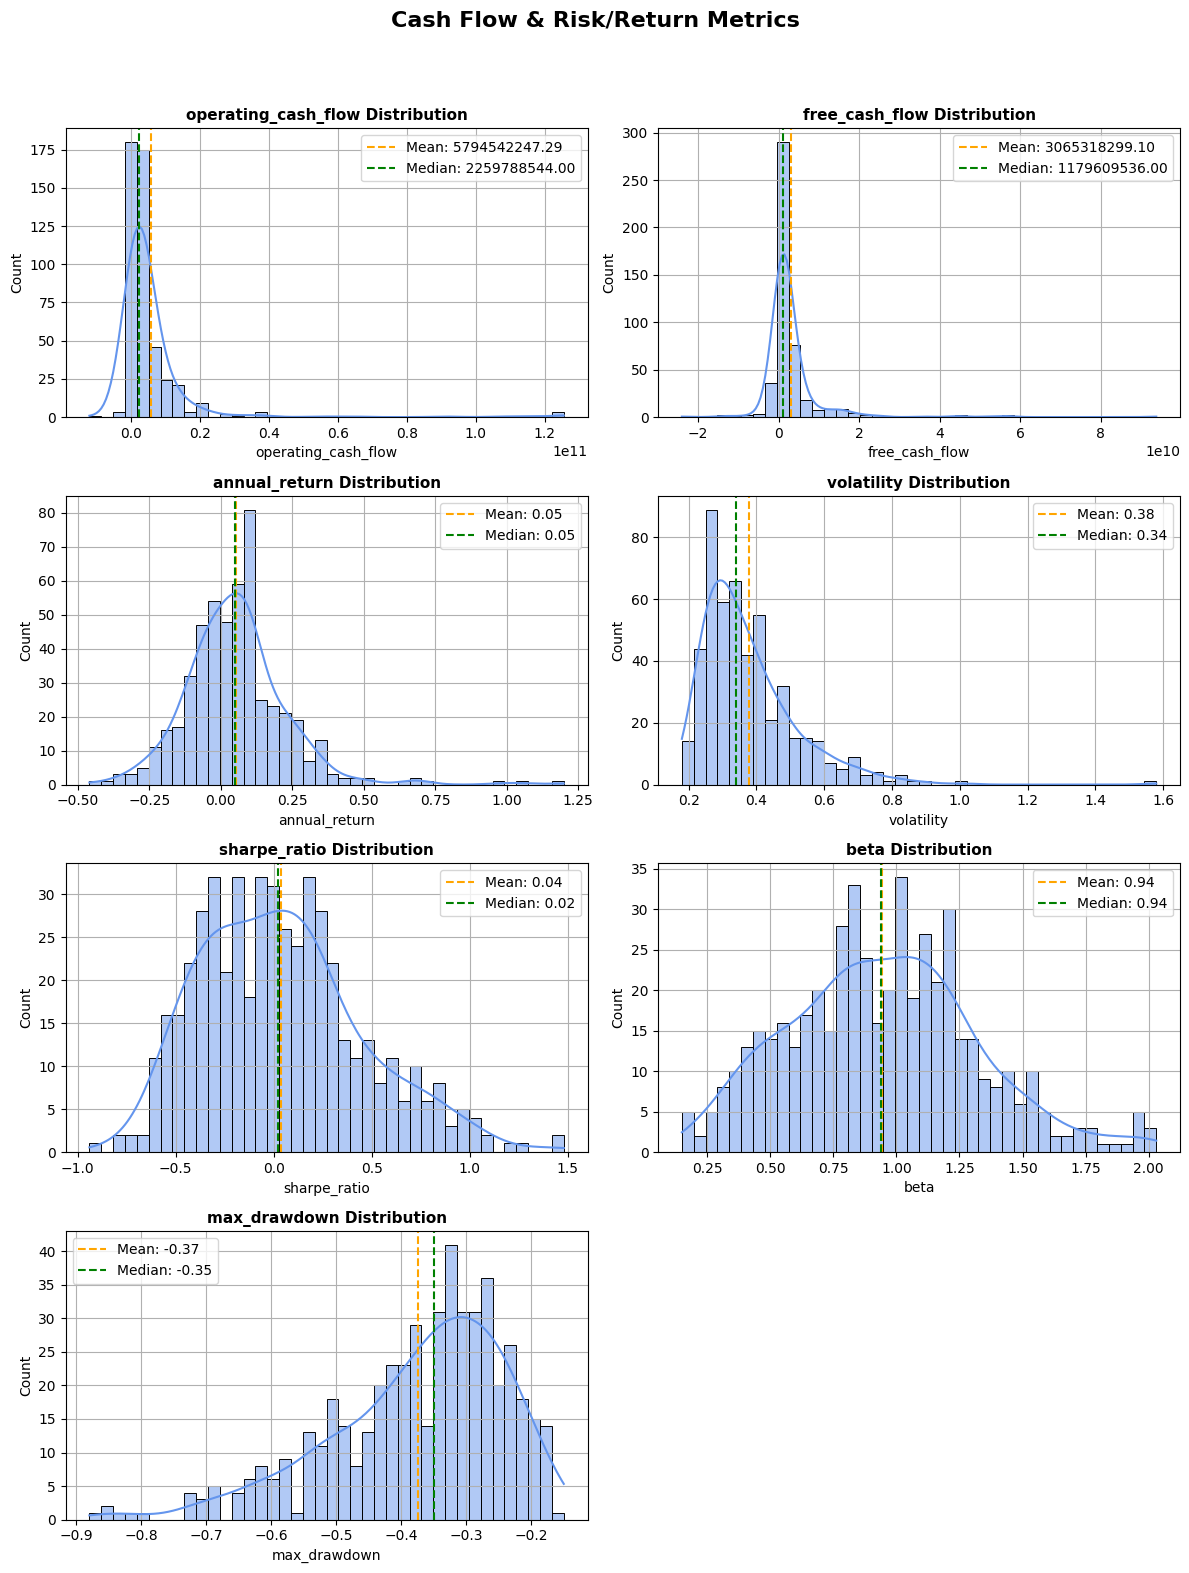

In [10]:
cashflow_risk_metrics = [
    'operating_cash_flow', 
    'free_cash_flow',
    'annual_return', 
    'volatility', 
    'sharpe_ratio', 
    'beta',
    'max_drawdown'
]
check_distribution(merged_df, cashflow_risk_metrics, title="Cash Flow & Risk/Return Metrics")

In [11]:
# Merge the DataFrames
merged_df = pd.merge(fundamentals_df, risk_df, on='stock_id', how='inner')
merged_df = pd.merge(merged_df, sp500_df[['stock_id', 'ticker','sector']], on='stock_id', how = 'inner')
merged_df

# Drop extra features
merged_df = merged_df.drop(['peg_ratio', 'created_at_x', 'created_at_y','market_cap'], axis =1 ).copy()
merged_df

# droping rows where nans are > 6
row_missing = merged_df.isna().sum(axis = 1)
removed_data = merged_df.loc[row_missing >=10]
merged_df = merged_df.loc[row_missing < 10]
merged_df.describe().T


count          mean           std           min  \
stock_id             501.0  9.102517e+05  1.451700e+02  9.100000e+05   
trailing_pe          479.0  6.614164e+01  6.757222e+02  4.217300e+00   
forward_pe           501.0  2.184782e+01  2.834499e+01 -6.207692e+01   
price_to_book        501.0  4.722406e+00  4.010967e+01 -4.234534e+02   
price_to_sales       501.0  4.340215e+00  5.410832e+00  6.254610e-02   
profit_margin        501.0  1.407867e-01  1.450893e-01 -1.100430e+00   
return_on_equity     468.0  3.436388e-01  1.388808e+00 -1.249360e+00   
return_on_assets     494.0  6.804316e-02  5.862790e-02 -1.514100e-01   
revenue_growth       499.0  6.801202e-02  1.523747e-01 -6.560000e-01   
eps_growth           426.0  3.910047e-01  1.542287e+00 -9.940000e-01   
dividend_yield       501.0  2.021130e-02  1.808279e-02  0.000000e+00   
debt_to_equity       450.0  1.602499e+02  4.707103e+02  1.100000e-01   
current_ratio        476.0  1.613836e+00  1.580930e+00  5.900000e-02   
operating_cash_flow  476.0  5.794542e+09  1.405389e+10 -1.208000e+10   
free_cash_flow       468.0  3.065318e+09  8.051876e+09 -2.404287e+10   
annual_return        501.0  5.203593e-02  1.803004e-01 -4.600000e-01   
volatility           501.0  3.776048e-01  1.441883e-01  1.800000e-01   
sharpe_ratio         501.0  3.648703e-02  4.138169e-01 -9.400000e-01   
beta                 501.0  9.448104e-01  3.711504e-01  1.500000e-01   
max_drawdown         501.0 -3.750299e-01  1.350417e-01 -8.800000e-01   

                              25%           50%           75%           max  
stock_id             9.101270e+05  9.102520e+05  9.103770e+05  9.105020e+05  
trailing_pe          1.521806e+01  2.298415e+01  3.380492e+01  1.475700e+04  
forward_pe           1.195628e+01  1.737805e+01  2.438261e+01  4.274063e+02  
price_to_book        1.637962e+00  2.985604e+00  6.432572e+00  4.083030e+02  
price_to_sales       1.497514e+00  2.978432e+00  5.507872e+00  7.975039e+01  
profit_margin        7.259000e-02  1.283200e-01  2.016600e-01  8.095200e-01  
return_on_equity     8.867250e-02  1.600350e-01  2.943900e-01  2.731250e+01  
return_on_assets     3.028500e-02  5.497500e-02  8.718000e-02  5.741700e-01  
revenue_growth       3.500000e-03  4.900000e-02  1.145000e-01  1.634000e+00  
eps_growth          -1.177500e-01  7.650000e-02  3.115000e-01  1.395700e+01  
dividend_yield       5.417485e-03  1.682760e-02  3.122663e-02  9.957325e-02  
debt_to_equity       3.843900e+01  7.452700e+01  1.456780e+02  8.150811e+03  
current_ratio        8.900000e-01  1.253000e+00  1.772500e+00  2.118500e+01  
operating_cash_flow  1.191725e+09  2.259789e+09  5.015000e+09  1.255830e+11  
free_cash_flow       6.185334e+08  1.179610e+09  2.839438e+09  9.383387e+10  
annual_return       -5.000000e-02  5.000000e-02  1.200000e-01  1.200000e+00  
volatility           2.800000e-01  3.400000e-01  4.400000e-01  1.580000e+00  
sharpe_ratio        -2.800000e-01  2.000000e-02  2.700000e-01  1.480000e+00  
beta                 6.900000e-01  9.400000e-01  1.190000e+00  2.030000e+00  
max_drawdown        -4.500000e-01 -3.500000e-01 -2.700000e-01 -1.500000e-01

## 1.2.  Spot sector bias
Before any scaling or cleaning, each sector already shows its own “fingerprint.”  
The table below few observations explains why we can’t throw the raw numbers straight into K-Means.

| Theme | What we see in the raw numbers (before scaling) | Why it matters for our model |
|-------|-------------------------------------------------|------------------------------|
| **Valuation** | **Real-Estate** stocks carry the heftiest price tags (≈ 35 × earnings, 8 × sales). **Energy** and **banks** trade much cheaper (≈ 12–14 × earnings). | If we cluster on these prices as-is, the model will only split “pricey property” from “cheap oil/banks.” We need sector-neutral scaling first. |
| **Profitability** | **Tech** keeps the biggest slice of revenue (profit margin ~ 18 %, ROA ~ 10 %). **Utilities** keep the smallest slice. | Confirms common sense—software beats power plants. The raw data passes the smell test. |
| **Leverage** | **Utilities** borrow the most (debt > 2 × equity). **Tech** and **Health-Care** stay below 0.6 ×. | Missing debt numbers will be filled with the **sector** median, not a market-wide average, to avoid understating risk. |
| **Liquidity** | **Real-Estate trusts** have the highest current ratio (~ 1.8). **Banks** show near-zero (their balance sheets work differently). | Reinforces why a single ‘average’ fill value is meaningless—every sector needs its own scale. |
| **Risk & Return** | **Tech** delivers the best Sharpe (> 1) but also swings more (beta ~ 1.3). **Utilities** are steadier: low beta (~ 0.3), smaller drawdowns. | Classic patterns reassure us the data is sensible and signal that z-scoring (putting metrics on a common risk scale) is the right next step. |

**Key take-away:** *Every* fundamental metric is **heavily shaped by sector**.  
To reveal truly “cheap” or “high-growth” stocks, we’ll first neutralise these sector effects—otherwise our clusters would merely repeat the obvious industry splits.


In [12]:
import math
def sector_comparision(data, feature):
    ncols = 4
    nrows = math.ceil(len(feature) / ncols)


    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*4), constrained_layout=True)
    axes = axes.flatten()
    for ax, feat in zip(axes, feature):
        sns.barplot(x='sector', y=feat, data=data, ax=ax, color='cornflowerblue')
        ax.set_title(feat,fontsize=12)
        ax.tick_params(axis='x', rotation=90, labelsize=10)     # smaller labels
        ax.tick_params(axis='y', labelsize=8)
        ax.set_xlabel('')
        ax.set_ylabel('Median', fontsize=8)

    for ax in axes[len(feature):]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

In [13]:
def outlier_detection(data):

    plt.figure(figsize=(12,10))

    for i, j in enumerate(data.describe().columns):
        plt.subplot(5,5, i+1)
        sns.boxplot(x=data[j])
        plt.title('{}'.format(j))
        plt.tight_layout()
    
    #plt.savefig('box.png')
    plt.show()

/tmp/ipykernel_19/905088737.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


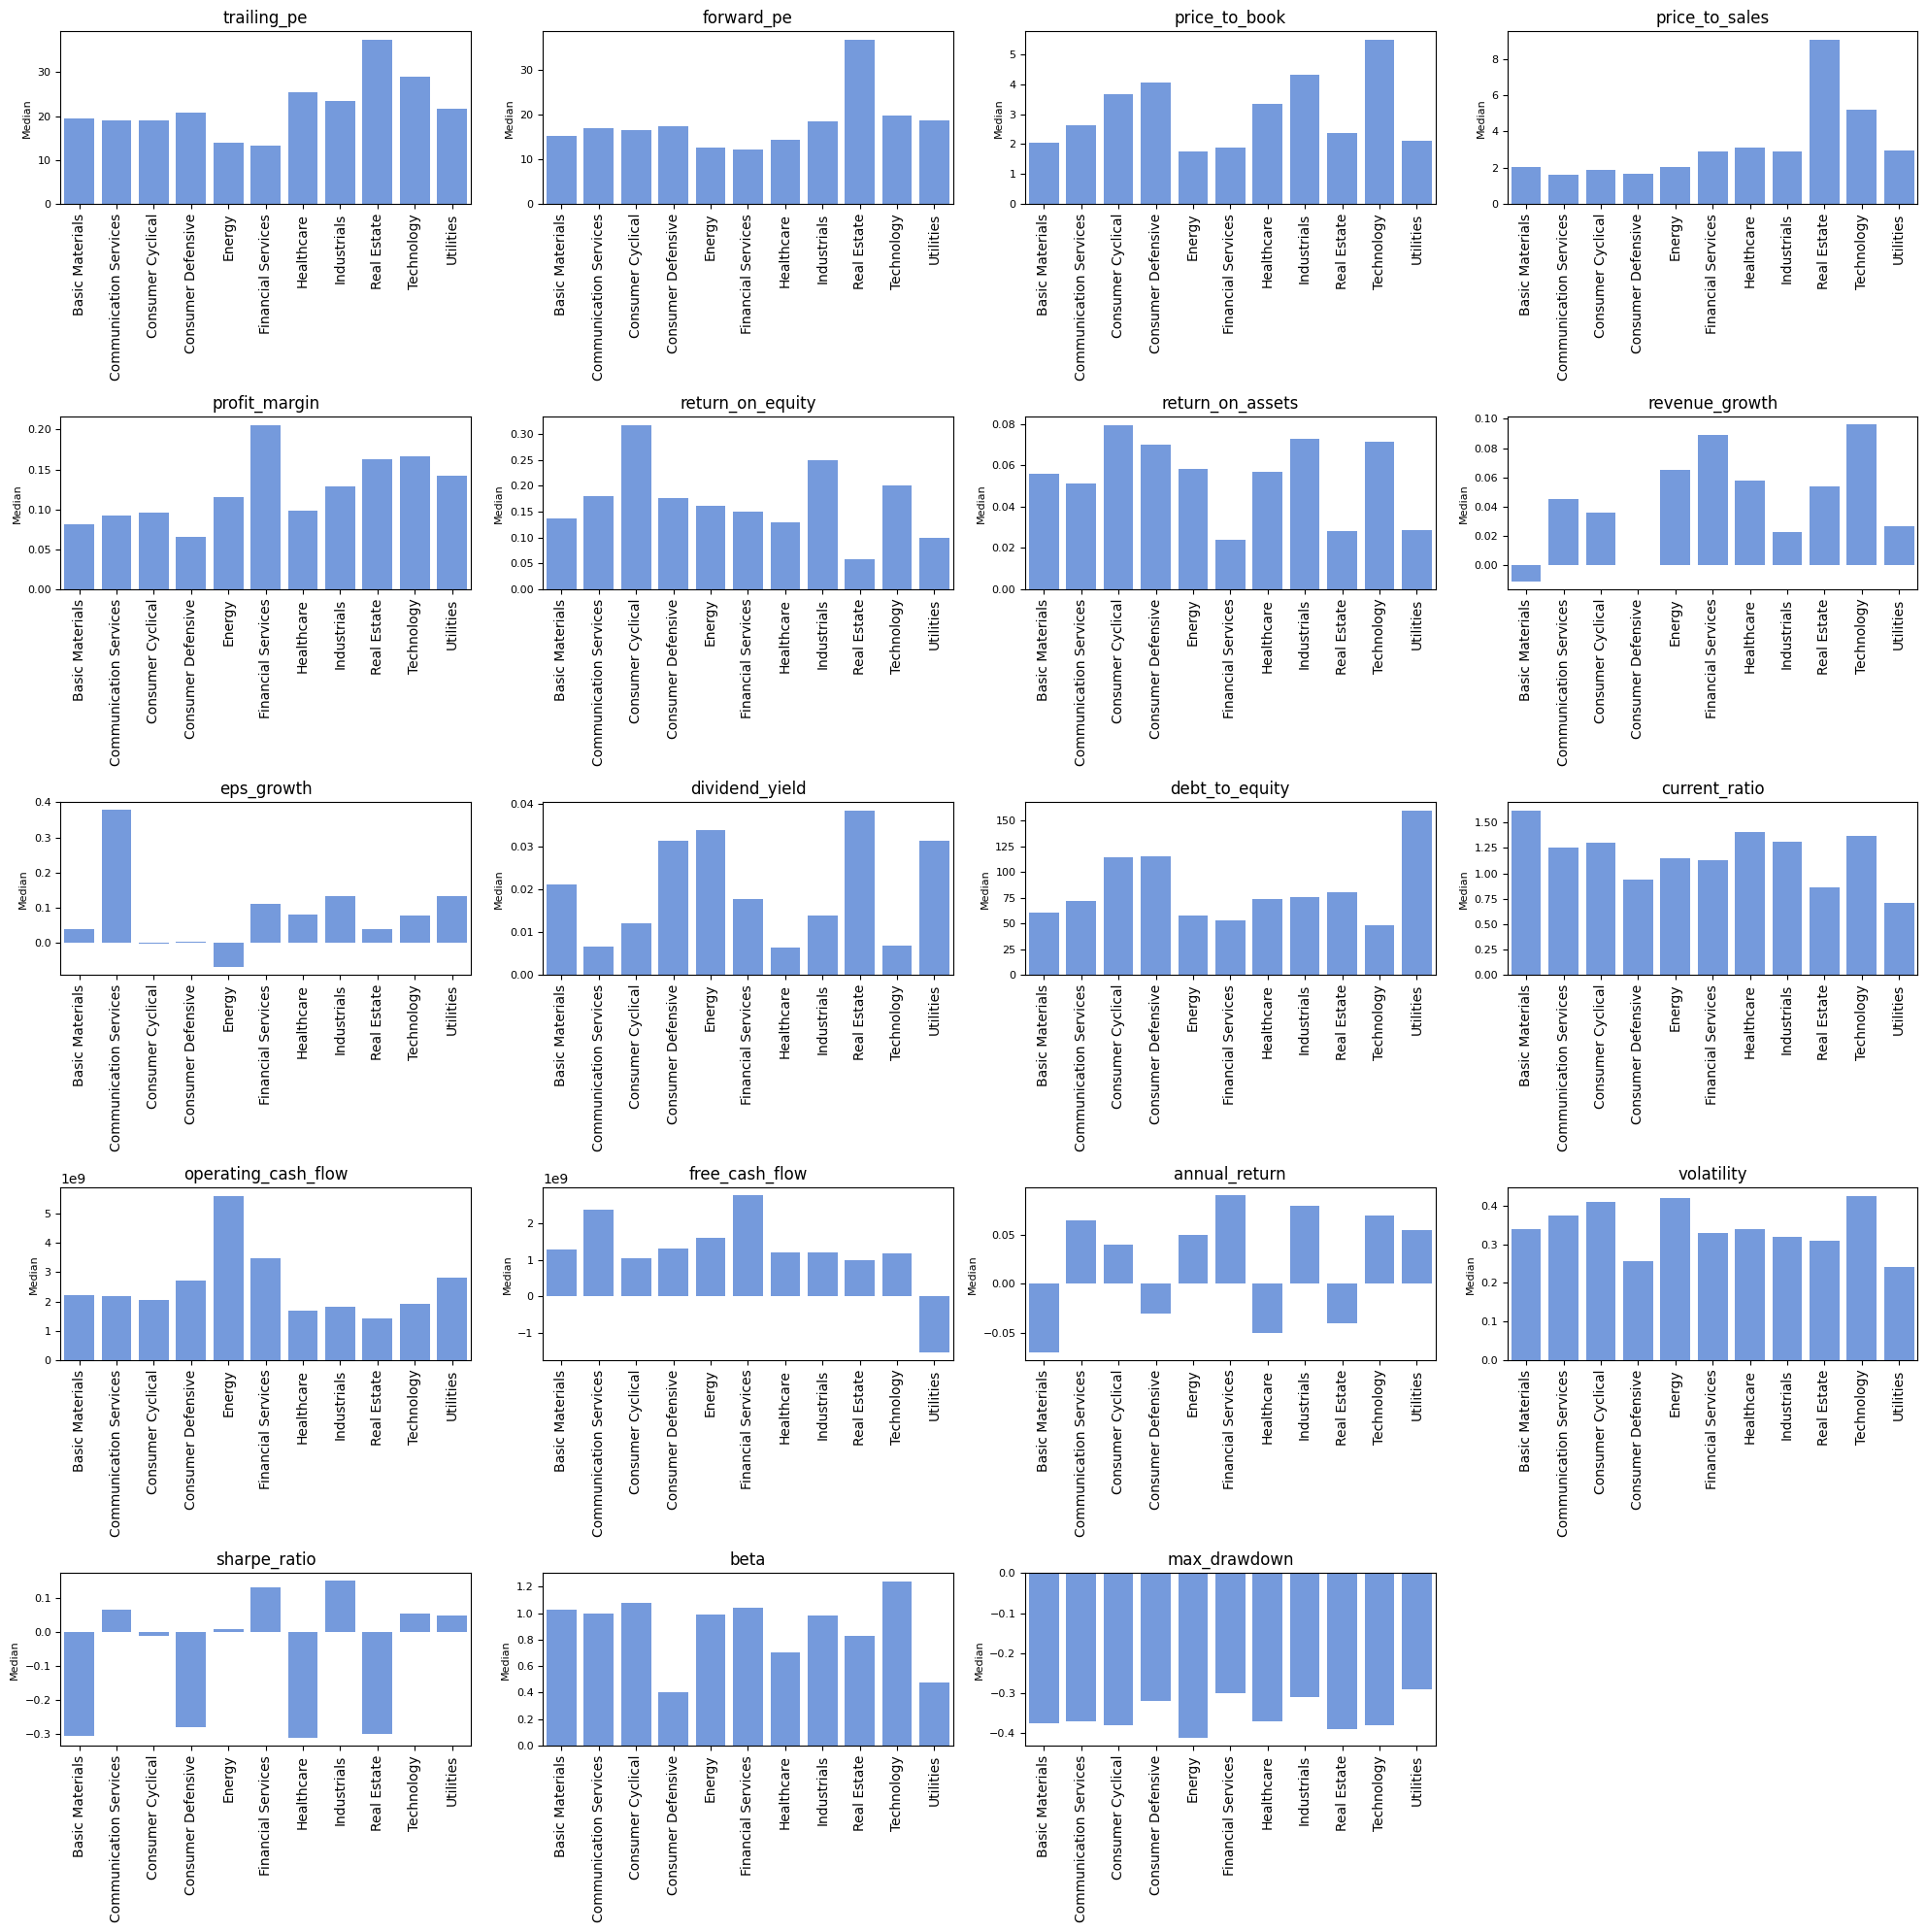

In [14]:
# Sector wise comparision median data as mean will be susceptible to outliers
feature = merged_df.columns[0:-2].tolist()
median_df = merged_df.groupby('sector')[feature].median().reset_index()
features = merged_df.columns[1:-2].tolist()
sector_comparision(median_df, features)

/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739

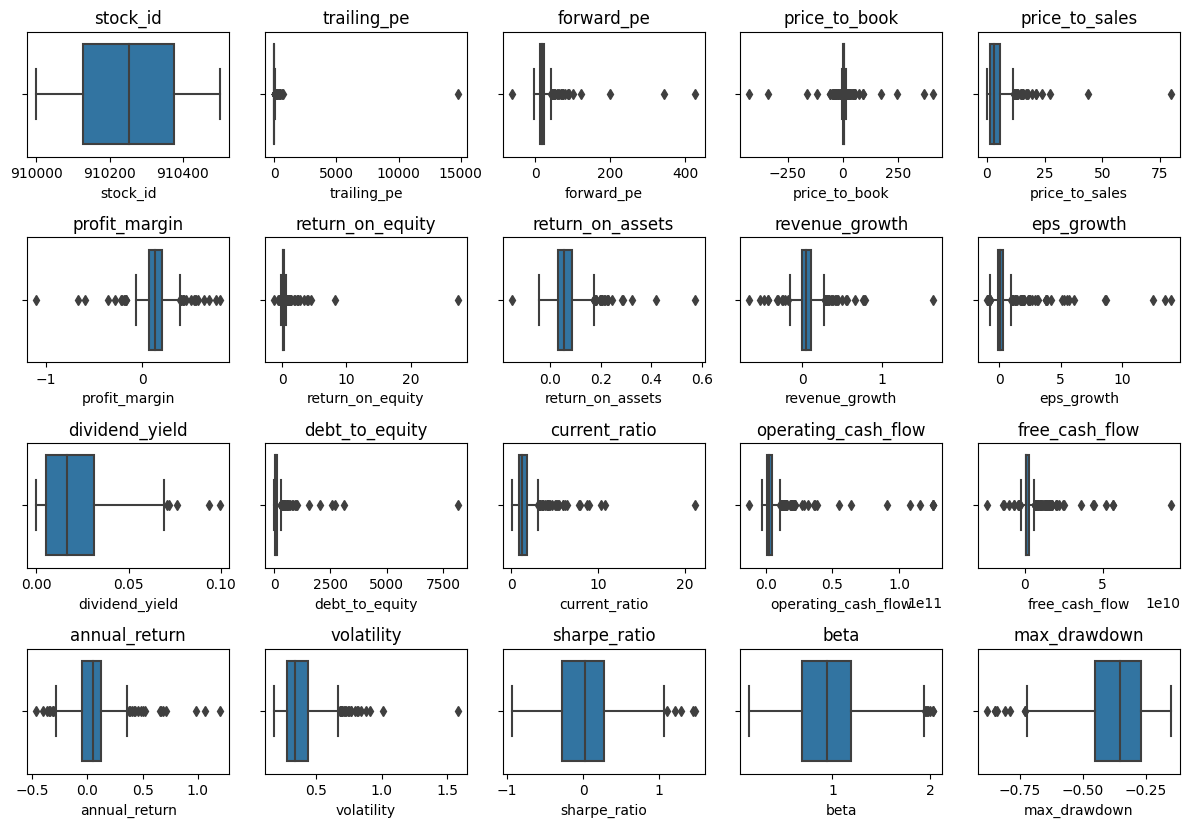

In [15]:
outlier_detection(merged_df)

In [16]:
sector_list = merged_df.sector.unique().tolist()
features = ['trailing_pe', 'forward_pe', 'price_to_book',
       'price_to_sales', 'profit_margin', 'return_on_equity',
       'return_on_assets', 'revenue_growth', 'eps_growth', 'dividend_yield',
       'debt_to_equity', 'current_ratio', 'operating_cash_flow',
       'free_cash_flow', 'annual_return', 'volatility', 'sharpe_ratio', 'beta',
       'max_drawdown']

In [17]:
merged_df[features].describe().T

count          mean           std           min  \
trailing_pe          479.0  6.614164e+01  6.757222e+02  4.217300e+00   
forward_pe           501.0  2.184782e+01  2.834499e+01 -6.207692e+01   
price_to_book        501.0  4.722406e+00  4.010967e+01 -4.234534e+02   
price_to_sales       501.0  4.340215e+00  5.410832e+00  6.254610e-02   
profit_margin        501.0  1.407867e-01  1.450893e-01 -1.100430e+00   
return_on_equity     468.0  3.436388e-01  1.388808e+00 -1.249360e+00   
return_on_assets     494.0  6.804316e-02  5.862790e-02 -1.514100e-01   
revenue_growth       499.0  6.801202e-02  1.523747e-01 -6.560000e-01   
eps_growth           426.0  3.910047e-01  1.542287e+00 -9.940000e-01   
dividend_yield       501.0  2.021130e-02  1.808279e-02  0.000000e+00   
debt_to_equity       450.0  1.602499e+02  4.707103e+02  1.100000e-01   
current_ratio        476.0  1.613836e+00  1.580930e+00  5.900000e-02   
operating_cash_flow  476.0  5.794542e+09  1.405389e+10 -1.208000e+10   
free_cash_flow       468.0  3.065318e+09  8.051876e+09 -2.404287e+10   
annual_return        501.0  5.203593e-02  1.803004e-01 -4.600000e-01   
volatility           501.0  3.776048e-01  1.441883e-01  1.800000e-01   
sharpe_ratio         501.0  3.648703e-02  4.138169e-01 -9.400000e-01   
beta                 501.0  9.448104e-01  3.711504e-01  1.500000e-01   
max_drawdown         501.0 -3.750299e-01  1.350417e-01 -8.800000e-01   

                              25%           50%           75%           max  
trailing_pe          1.521806e+01  2.298415e+01  3.380492e+01  1.475700e+04  
forward_pe           1.195628e+01  1.737805e+01  2.438261e+01  4.274063e+02  
price_to_book        1.637962e+00  2.985604e+00  6.432572e+00  4.083030e+02  
price_to_sales       1.497514e+00  2.978432e+00  5.507872e+00  7.975039e+01  
profit_margin        7.259000e-02  1.283200e-01  2.016600e-01  8.095200e-01  
return_on_equity     8.867250e-02  1.600350e-01  2.943900e-01  2.731250e+01  
return_on_assets     3.028500e-02  5.497500e-02  8.718000e-02  5.741700e-01  
revenue_growth       3.500000e-03  4.900000e-02  1.145000e-01  1.634000e+00  
eps_growth          -1.177500e-01  7.650000e-02  3.115000e-01  1.395700e+01  
dividend_yield       5.417485e-03  1.682760e-02  3.122663e-02  9.957325e-02  
debt_to_equity       3.843900e+01  7.452700e+01  1.456780e+02  8.150811e+03  
current_ratio        8.900000e-01  1.253000e+00  1.772500e+00  2.118500e+01  
operating_cash_flow  1.191725e+09  2.259789e+09  5.015000e+09  1.255830e+11  
free_cash_flow       6.185334e+08  1.179610e+09  2.839438e+09  9.383387e+10  
annual_return       -5.000000e-02  5.000000e-02  1.200000e-01  1.200000e+00  
volatility           2.800000e-01  3.400000e-01  4.400000e-01  1.580000e+00  
sharpe_ratio        -2.800000e-01  2.000000e-02  2.700000e-01  1.480000e+00  
beta                 6.900000e-01  9.400000e-01  1.190000e+00  2.030000e+00  
max_drawdown        -4.500000e-01 -3.500000e-01 -2.700000e-01 -1.500000e-01

## 1.3. Missing Value

In [18]:
# Check for missing values
print("🔍 Missing values in selected features:")
print(merged_df[features].isnull().sum())

#Check for problematic values (e.g. zero or negative before log-transform)
print("\n🚨 Zero or negative values:")
for col in features:
    print(f"{col}: {(merged_df[col] < 0).sum()} zero/negative values")


🔍 Missing values in selected features:
trailing_pe            22
forward_pe              0
price_to_book           0
price_to_sales          0
profit_margin           0
return_on_equity       33
return_on_assets        7
revenue_growth          2
eps_growth             75
dividend_yield          0
debt_to_equity         51
current_ratio          25
operating_cash_flow    25
free_cash_flow         33
annual_return           0
volatility              0
sharpe_ratio            0
beta                    0
max_drawdown            0
dtype: int64

🚨 Zero or negative values:
trailing_pe: 0 zero/negative values
forward_pe: 2 zero/negative values
price_to_book: 32 zero/negative values
price_to_sales: 0 zero/negative values
profit_margin: 22 zero/negative values
return_on_equity: 19 zero/negative values
return_on_assets: 8 zero/negative values
revenue_growth: 121 zero/negative values
eps_growth: 165 zero/negative values
dividend_yield: 0 zero/negative values
debt_to_equity: 0 zero/negative values

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


In [19]:
#median_df.set_index('sector', inplace= True)
median_df[['return_on_assets','debt_to_equity','current_ratio','free_cash_flow','revenue_growth']]

return_on_assets  debt_to_equity  current_ratio  free_cash_flow  \
0           0.055860         60.4855         1.6200    1.274875e+09   
1           0.051245         71.9710         1.2505    2.358062e+09   
2           0.079580        114.9515         1.3020    1.051250e+09   
3           0.070030        115.5830         0.9390    1.303982e+09   
4           0.058410         58.1610         1.1520    1.595500e+09   
5           0.023900         52.9710         1.1285    2.758725e+09   
6           0.056830         73.8555         1.4110    1.197112e+09   
7           0.072680         75.6290         1.3160    1.195125e+09   
8           0.028460         80.5995         0.8650    1.002340e+09   
9           0.071610         48.2770         1.3735    1.173069e+09   
10          0.028550        160.1110         0.7090   -1.533063e+09   

    revenue_growth  
0          -0.0110  
1           0.0455  
2           0.0360  
3           0.0005  
4           0.0650  
5           0.0890  
6           0.0580  
7           0.0230  
8           0.0540  
9           0.0960  
10          0.0265

# 2 : Data preprocessing

## 2.1. Sector‑median imputation
> - Fill missing values with the median of the stock’s own sector peers (e.g. a utility missing debt‑to‑equity inherits the utilities median).  
> - Metrics with > 10 % missingness (e.g. EPS growth) are dropped.

In [20]:
missing_features = ['trailing_pe','return_on_equity','return_on_assets','debt_to_equity','current_ratio','free_cash_flow','revenue_growth','operating_cash_flow']

clean_data = merged_df[features].copy()
clean_data['sector'] = merged_df['sector']


for col in missing_features:
    # This line fills NaNs within each sector with that sector's median.
    clean_data[col] = clean_data.groupby('sector')[col].transform(lambda x: x.fillna(x.median()))
    

In [21]:
#print(clean_data[selected_features].isnull().sum())
    # Sector Neutralization - To remove sector bias - Median of each sector
#_clean_data = clean_data.copy()
#for feature in selected_features:
#    neutralized_data= _clean_data.groupby('sector')[feature].transform(lambda x: x - x.median())
#    _clean_data[feature] = neutralized_data
        

for col in features:
    print(f"{col}: {(clean_data[col] == 0).sum()} zero/negative values")

clean_data['revenue_growth'].min()


trailing_pe: 0 zero/negative values
forward_pe: 0 zero/negative values
price_to_book: 0 zero/negative values
price_to_sales: 0 zero/negative values
profit_margin: 0 zero/negative values
return_on_equity: 0 zero/negative values
return_on_assets: 0 zero/negative values
revenue_growth: 0 zero/negative values
eps_growth: 1 zero/negative values
dividend_yield: 96 zero/negative values
debt_to_equity: 0 zero/negative values
current_ratio: 0 zero/negative values
operating_cash_flow: 0 zero/negative values
free_cash_flow: 0 zero/negative values
annual_return: 10 zero/negative values
volatility: 0 zero/negative values
sharpe_ratio: 0 zero/negative values
beta: 0 zero/negative values
max_drawdown: 0 zero/negative values


-0.656

## 2.2. Transformation 
> - **Yeo‑Johnson power transform** — combats heavy tails while accommodating zeros and negatives.

In [22]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import QuantileTransformer

def yeo_transforn(data,selected_features):
    pt = PowerTransformer(method='yeo-johnson', standardize=False)
    _transformed_data = [pt.fit_transform(data[selected_features])]
    return _transformed_data, pt.lambdas_

def robust_scaler(data):
    scaler = RobustScaler(quantile_range=(1,99))
    scaled = scaler.fit_transform(data)
    #for feat, scale in zip(data.columns, scaler.scale_):
        #print(f"{feat}: IQR = {scale:.3f}")
    
    return scaled

def quantile_scaler(data):
    qt = QuantileTransformer(output_distribution='normal', n_quantiles=200, random_state=42)
    data_qt = qt.fit_transform(data)
    return data_qt

def Standard_scaler(data):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)
    return X_scaled

In [23]:
# Trying log transformation before for columns price to book, free cash flow and debt to equity (Ignore)
new_data = clean_data.copy()
from sklearn.preprocessing import FunctionTransformer
positive_vals_feature = ['debt_to_equity', 'price_to_sales','current_ratio']    # need to shift x>0
negative_vals_feature = [ 'revenue_growth', 'return_on_assets', 'profit_margin', 'volatility', 'annual_return']
eps = 1e-6
deltas = new_data[negative_vals_feature].min(axis=0).abs()+ eps

plain_log_tf = FunctionTransformer(
    func = lambda X: np.log1p(X),
    inverse_func = lambda X: np.expm1(X) - deltas,
    validate= False
)

shift_log_tf = FunctionTransformer(
    func=lambda X: np.log1p(X + deltas),
    inverse_func=lambda X: np.expm1(X) - deltas,
    validate=False
)

new_data[positive_vals_feature] = plain_log_tf.transform(new_data[positive_vals_feature])
new_data[positive_vals_feature]
print(new_data[positive_vals_feature].skew())
#check_distribution(clean_data, positive_vals_feature)
#check_distribution(new_data, positive_vals_feature)

debt_to_equity   -0.265664
price_to_sales    0.456966
current_ratio     1.532643
dtype: float64


In [24]:
# New data represents the transformed data.

#feature_for_transfromation = ['forward_pe','price_to_book','price_to_sales','profit_margin','return_on_assets','revenue_growth',
# 'dividend_yield','debt_to_equity','current_ratio','free_cash_flow','annual_return','volatility','max_drawdown']
_transformed_data, _lambda = yeo_transforn(clean_data[features].copy(), features)

_power_transformed = pd.DataFrame(_transformed_data[0], columns= features)
_power_transformed[['beta','sharpe_ratio']] = clean_data[['beta','sharpe_ratio']]

raw_skew = pd.DataFrame(clean_data, columns= features).skew()   
tf_skew  = pd.DataFrame(_power_transformed, columns= features).skew().abs()
print(pd.concat([raw_skew, tf_skew], axis=1, keys=['Initial','Transformed']))
#check_distribution(_power_transformed, features)

                       Initial  Transformed
trailing_pe          22.083312     0.065251
forward_pe            9.540613     3.250390
price_to_book         0.155045     2.789511
price_to_sales        6.899332     0.020574
profit_margin        -1.155455     0.310460
return_on_equity     16.895286     2.211757
return_on_assets      2.542493     0.431972
revenue_growth        2.607004     0.327371
eps_growth            5.553099     0.273175
dividend_yield        1.013759     0.144491
debt_to_equity       13.045521     0.035548
current_ratio         5.985924     0.046796
operating_cash_flow   6.756228     5.513256
free_cash_flow        5.917730     4.388737
annual_return         1.401988     0.084614
volatility            2.231740     0.131223
sharpe_ratio          0.591328     0.591328
beta                  0.322363     0.322363
max_drawdown         -0.951692     0.061717


## 2.3 Sector-neutral robust scaling
> - Sector-by-sector centring plus IQR scaling
> - Centering by the sector median removes the automatic “Tech looks pricey, Utilities look cheap” effect. The algorithm can now discover stocks that are genuinely expensive or cheap relative to their own peers, which is what investors really care about.

| Step | Formula | Purpose |
|------|---------|---------|
| Centre | (x' = x - median_sector) | Subtract the sector median so each metric is measured relative to its own sector. After centering, a value of 0 means the company is exactly at the sector median for that metric |
| Scale  | (z = x'/IQR_sector) | Expresses every value in **sector IQR units**, a robust spread measure immune to outliers. |

**Why we do this**  
- **Eliminate sector bias** – prevents K-Means from simply rebuilding the GICS grid.  
- **Tame outliers** – IQR ignores the noisiest tails, so extreme points can’t warp distances.  
- **Future-proof** – medians and IQRs update with each data refresh, adapting to regime shifts (e.g. rising P/Es in Tech).  
- **Common numeric scale** – a +2 z now means “two sector-IQRs above the median,” regardless of metric.

*Intuition*: after this transform, K-Means compares **relative factor tilts** across industries, not raw ratio levels.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

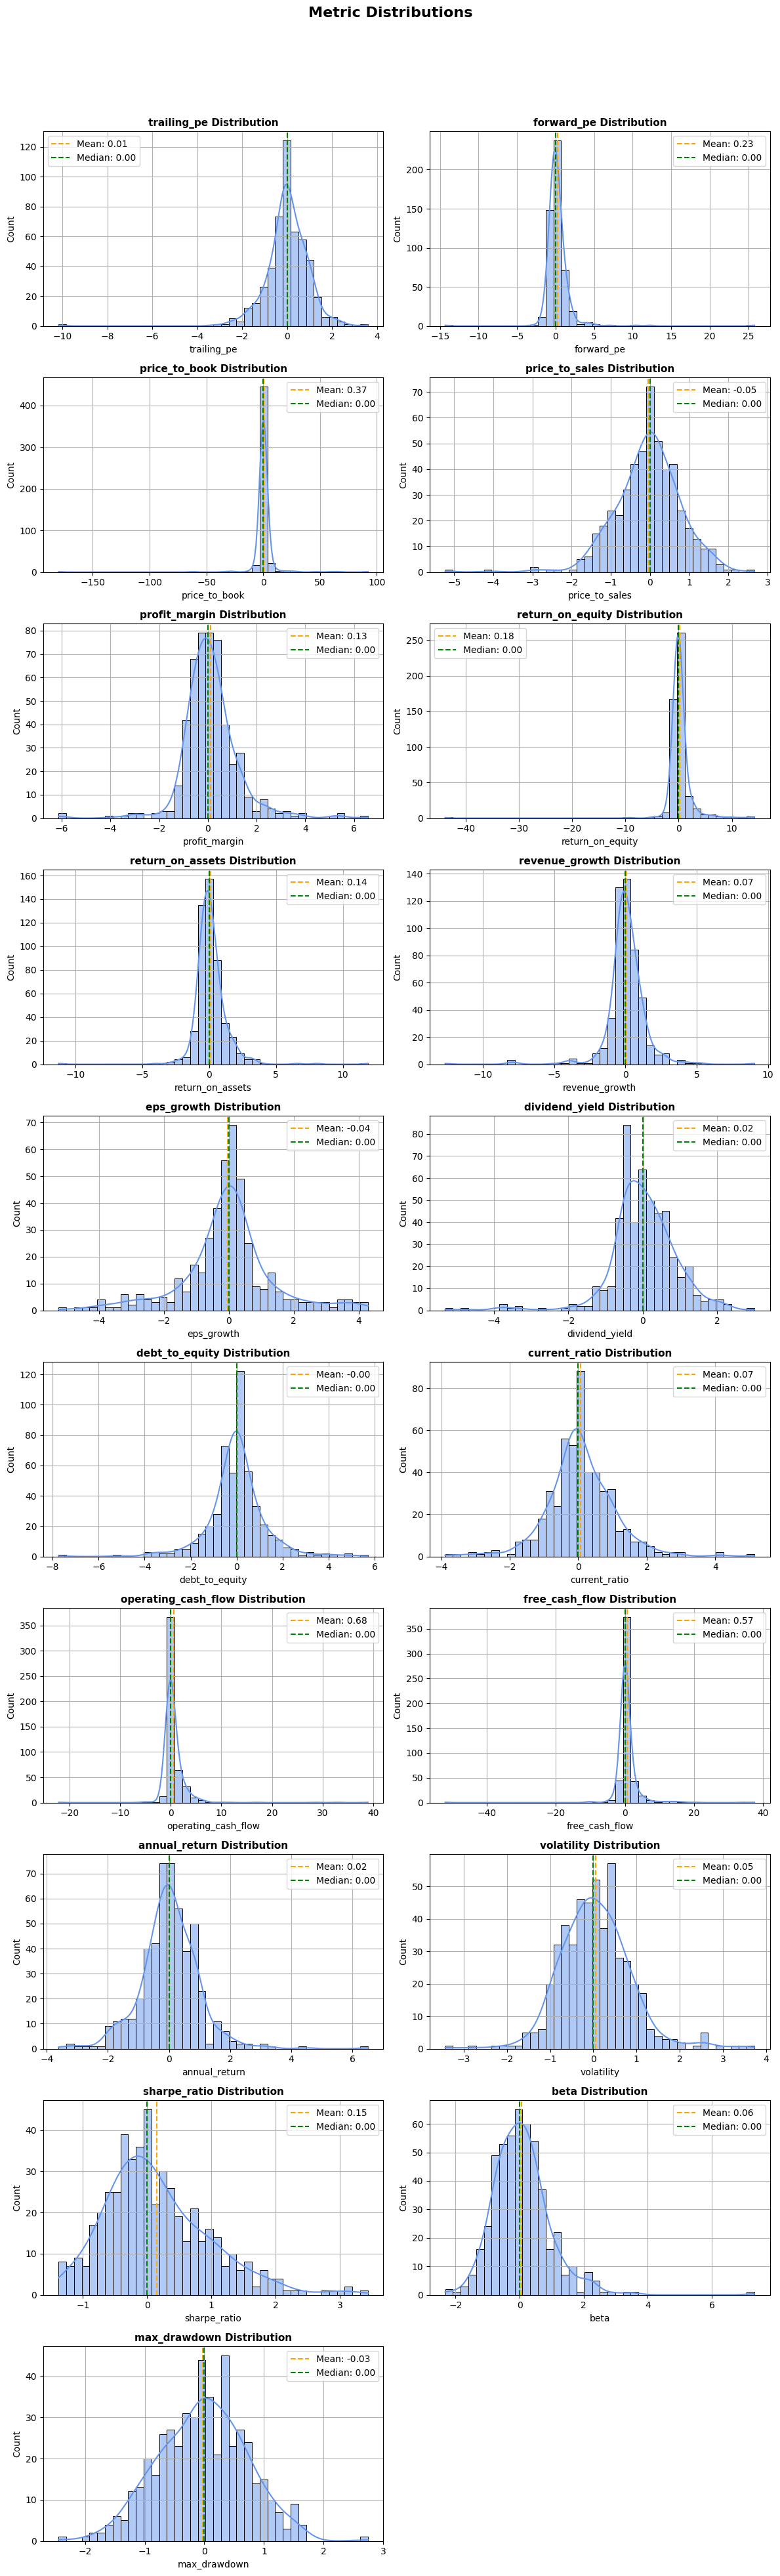

In [25]:
_neutralized_data = _power_transformed.copy()
_neutralized_data['sector'] = clean_data['sector']
for feature in features:
    neutralized_data= _neutralized_data.groupby('sector')[feature].transform(lambda x: (x - x.median()) / (x.quantile(0.75) - x.quantile(0.25)))
    _neutralized_data[feature] = neutralized_data
        
check_distribution(_neutralized_data, features)

In [26]:
# Sanity check for sector neutralzed data
#print(_neutralized_data.groupby('sector')[features].agg(lambda x: x.quantile(0.75) - x.quantile(0.25)))

In [27]:
_power_transformed['sector'] = clean_data['sector']

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


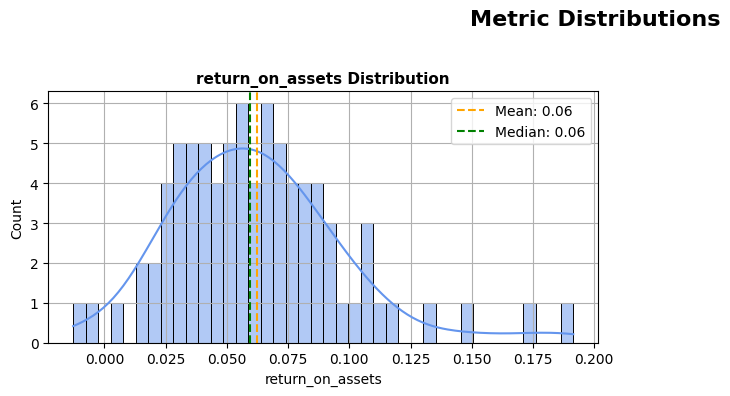

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


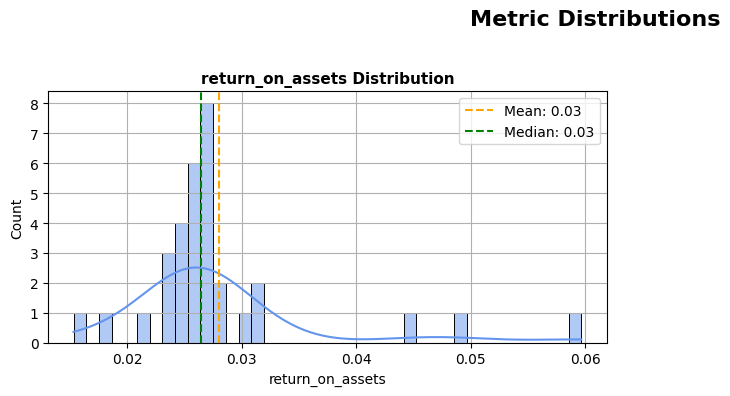

In [28]:
pe_tech_yeo = _power_transformed[_power_transformed['sector'] == 'Technology']
#pe_real_estate = merged_df[merged_df['sector'] == 'Real Estate']
pe_utilities_yeo = _power_transformed[_power_transformed['sector'] == 'Utilities']
check_distribution(pe_tech_yeo, ['return_on_assets'])
check_distribution(pe_utilities_yeo, ['return_on_assets'])

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


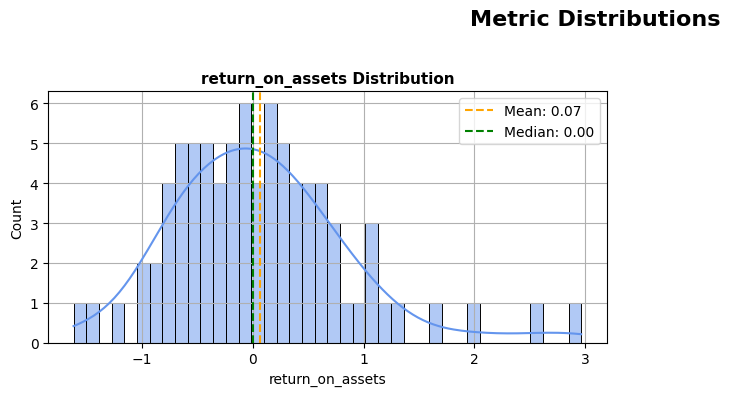

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


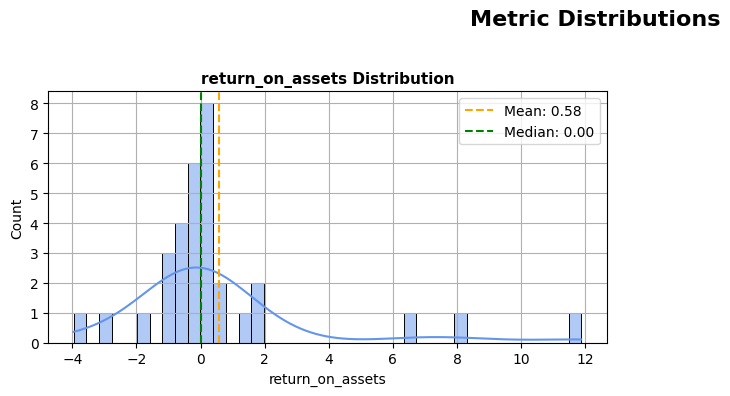

In [29]:
pe_tech_neutral = _neutralized_data[_neutralized_data['sector'] == 'Technology']
pe_real_estate_eutral = _neutralized_data[_neutralized_data['sector'] == 'Real Estate']
pe_utilities_neutral = _neutralized_data[_neutralized_data['sector'] == 'Utilities']
check_distribution(pe_tech_neutral, ['return_on_assets'])
check_distribution(pe_utilities_neutral, ['return_on_assets'])

## 2.4 Spread-Ratio Filter
To keep only metrics that show meaningful variation after cleaning, we score each one with a simple **spread ratio**:

Spread rati = IQR/Max - Min


> - **What it tells us**  A larger value means the middle 50 % of stocks already spans a good slice of the total range, so the metric separates *typical* companies—not just the outliers.
> - **What we did**  We kept a metric only if its spread ratio exceeded **0.04** (4 %, based on the data I have not an absolute value
). Anything lower was too flat and was dropped. This rule cut the feature set from 21 down to a lean core that genuinely distinguishes stocks.


In [30]:
pd.options.display.float_format = '{:.4f}'.format
def flat_feature_check(data, features, trim = 0.25, iqr_cut = 0.02, cv_cut = 0.3):
    Q1 = data[features].quantile(0.25)
    Q3 = data[features].quantile(0.75)
    min_ = data[features].min()
    max = data[features].max()
    _range = max - min_
    IQR = Q3 - Q1
    iqr_ratio = IQR / _range
    mask = iqr_ratio < iqr_cut
    data = pd.concat([min_, max, Q1, Q3, IQR, _range,iqr_ratio, mask], axis=1)
    data.rename(columns={0: 'Min', 1: 'Max', 0.25: 'Q1', 0.75: 'Q3', 2: 'IQR', 3: 'Range', 4: 'iqr_ratio', 5:'Middle 50% tight lump huge tail'}, inplace=True)
    return data

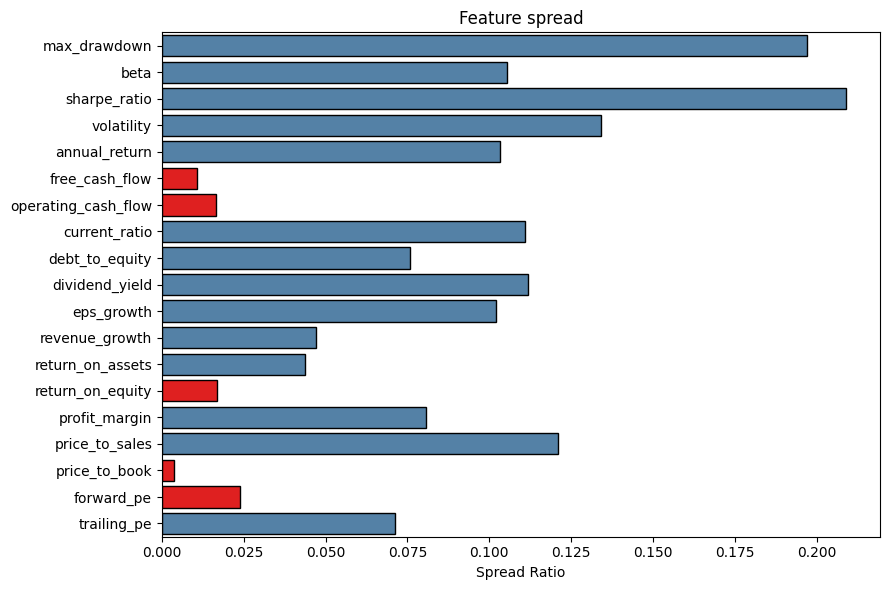

In [31]:
flat_data = flat_feature_check(_neutralized_data, features, iqr_cut=0.04)
plt.figure(figsize=(9, 6))
colors = flat_data["Middle 50% tight lump huge tail"].map(
    {True: "red", False: "steelblue"}).tolist()
sns.barplot(
    data = flat_data,
    y= flat_data.index,
    x='iqr_ratio',
    palette= colors,
    edgecolor="black"
)
plt.xlabel("Spread Ratio")
plt.ylabel("")
plt.title("Feature spread")
plt.gca().invert_yaxis()        # put widest spread at the top
plt.tight_layout()
plt.show()


In [32]:
final_data = _neutralized_data.copy()
final_data.drop(['price_to_book', 'free_cash_flow','forward_pe', 'operating_cash_flow', 'return_on_equity','eps_growth', 'sector' ], axis=1, inplace=True)
final_data

trailing_pe  price_to_sales  profit_margin  return_on_assets  \
0        -0.4345          0.0621         0.4553           -0.2431   
1        -0.5822         -0.1954         0.1236            0.9407   
2        -0.6160          0.3847         1.5858            0.0000   
3         1.1980          0.3972        -0.1494            0.7687   
4        -0.2698         -0.5847        -0.4470            0.6028   
..           ...             ...            ...               ...   
496       0.4352          0.1082        -0.2646           -0.5634   
497       0.6709          1.0144         1.4477            1.4042   
498      -0.3410         -0.6865        -0.5177           -0.1404   
499      -0.2318         -0.1299         0.1332           -0.3128   
500       0.0990          0.5825         1.2088            2.1565   

     revenue_growth  dividend_yield  debt_to_equity  current_ratio  \
0           -0.2308          0.9142          1.9083         0.1378   
1           -1.0895          0.4889         -2.0598         0.3240   
2           -0.2348          0.5874         -0.8885         0.0000   
3           -0.0259          1.2948          3.8902        -1.3860   
4           -0.3249          0.6364         -0.4144         0.0871   
..              ...             ...             ...            ...   
496          0.4273         -0.0391         -1.3997         0.5588   
497          1.0903          0.2902          0.0000         0.1992   
498          1.5615         -0.4037          0.2238         0.0502   
499         -0.1954          0.2080         -0.3552         0.5329   
500         -0.1430          0.3039          0.7306         0.3889   

     annual_return  volatility  sharpe_ratio    beta  max_drawdown  
0          -0.0508      0.3874       -0.1410 -0.6667       -0.6645  
1          -0.3151      0.0000       -0.3877 -0.3784       -0.2415  
2           0.7043     -0.9371        0.8261 -0.2432        0.6822  
3           0.7634     -0.7134        0.8913 -0.8378        1.0521  
4          -0.4816     -0.6763       -0.6386 -0.4494        0.5424  
..             ...         ...           ...     ...           ...  
496         0.1971     -0.2213        0.1762  0.0901        0.1737  
497         0.1227     -1.5190        0.2342 -1.0602        1.5289  
498        -1.4211      0.3893       -1.0964  0.5169       -0.5721  
499        -0.1395     -0.6092       -0.2391  0.1622        0.2542  
500        -0.0693     -0.1548       -0.0217  0.3514        0.3672  

[501 rows x 13 columns]

/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739

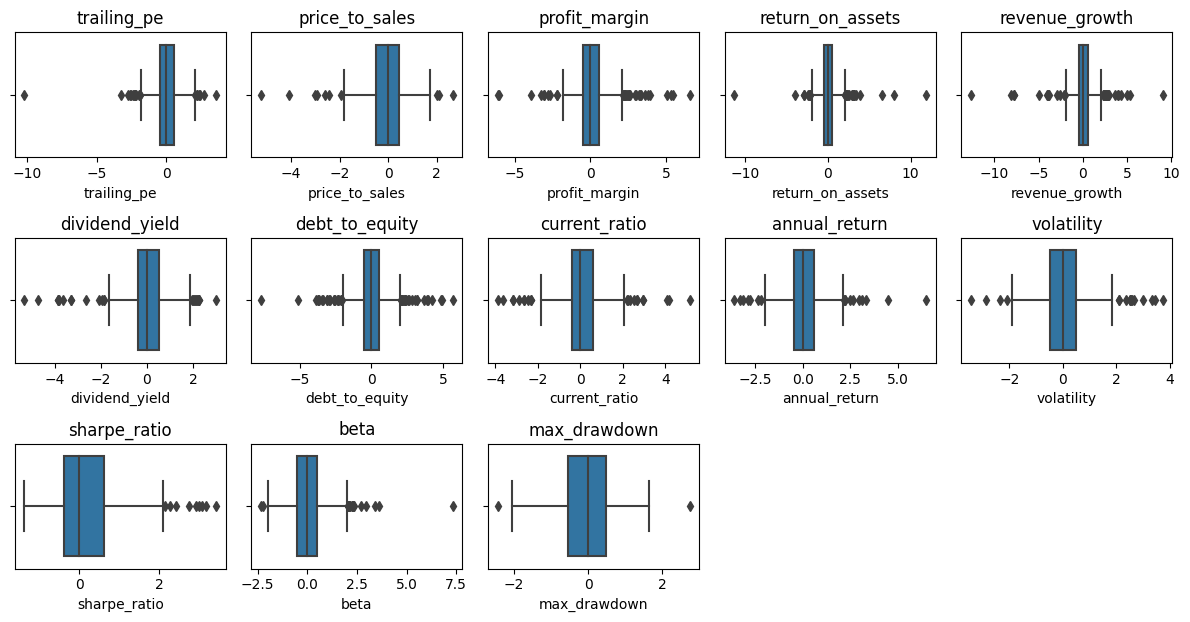

In [33]:
outlier_detection(final_data)

## 2.5.Winsorisation (±5 z)** 
> - Clips the outer ±1 % tails to stop outliers from dragging centroids.

In [34]:
# Wizorize data
# Flag part remaining
X_clipped = final_data.apply(lambda s: s.clip(-5, 5)).copy()
X_clipped

trailing_pe  price_to_sales  profit_margin  return_on_assets  \
0        -0.4345          0.0621         0.4553           -0.2431   
1        -0.5822         -0.1954         0.1236            0.9407   
2        -0.6160          0.3847         1.5858            0.0000   
3         1.1980          0.3972        -0.1494            0.7687   
4        -0.2698         -0.5847        -0.4470            0.6028   
..           ...             ...            ...               ...   
496       0.4352          0.1082        -0.2646           -0.5634   
497       0.6709          1.0144         1.4477            1.4042   
498      -0.3410         -0.6865        -0.5177           -0.1404   
499      -0.2318         -0.1299         0.1332           -0.3128   
500       0.0990          0.5825         1.2088            2.1565   

     revenue_growth  dividend_yield  debt_to_equity  current_ratio  \
0           -0.2308          0.9142          1.9083         0.1378   
1           -1.0895          0.4889         -2.0598         0.3240   
2           -0.2348          0.5874         -0.8885         0.0000   
3           -0.0259          1.2948          3.8902        -1.3860   
4           -0.3249          0.6364         -0.4144         0.0871   
..              ...             ...             ...            ...   
496          0.4273         -0.0391         -1.3997         0.5588   
497          1.0903          0.2902          0.0000         0.1992   
498          1.5615         -0.4037          0.2238         0.0502   
499         -0.1954          0.2080         -0.3552         0.5329   
500         -0.1430          0.3039          0.7306         0.3889   

     annual_return  volatility  sharpe_ratio    beta  max_drawdown  
0          -0.0508      0.3874       -0.1410 -0.6667       -0.6645  
1          -0.3151      0.0000       -0.3877 -0.3784       -0.2415  
2           0.7043     -0.9371        0.8261 -0.2432        0.6822  
3           0.7634     -0.7134        0.8913 -0.8378        1.0521  
4          -0.4816     -0.6763       -0.6386 -0.4494        0.5424  
..             ...         ...           ...     ...           ...  
496         0.1971     -0.2213        0.1762  0.0901        0.1737  
497         0.1227     -1.5190        0.2342 -1.0602        1.5289  
498        -1.4211      0.3893       -1.0964  0.5169       -0.5721  
499        -0.1395     -0.6092       -0.2391  0.1622        0.2542  
500        -0.0693     -0.1548       -0.0217  0.3514        0.3672  

[501 rows x 13 columns]

/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_19/2841287739

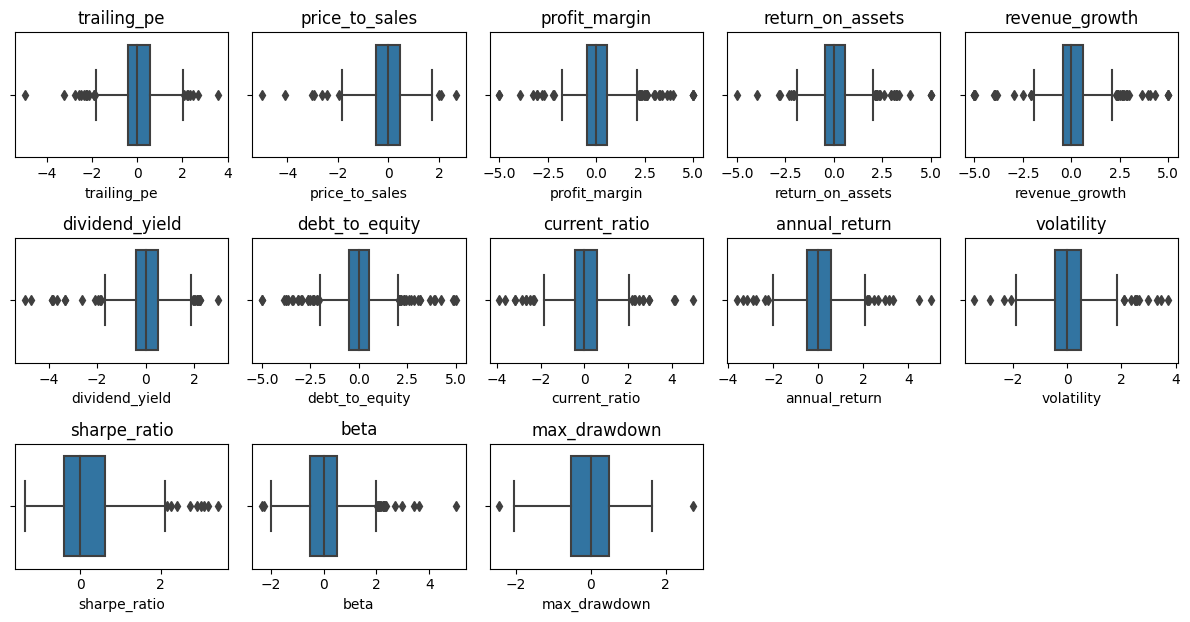

In [35]:
outlier_detection(X_clipped)

### Correlation check (exploratory)

The heat-map below isn’t part of the selection filter, but it helps spot any near-duplicate metrics.

* **Risk–return cluster:** `annual_return`, `sharpe_ratio`, and `volatility` are tightly linked  
  (`annual_return ↔ sharpe_ratio ≈ 0.90`, `volatility ↔ beta ≈ 0.72`,  
  `sharpe_ratio ↔ max_drawdown ≈ -0.77`).  
* **Valuation pair:** `trailing_pe` and `price_to_sales` are only **moderately** correlated (≈ 0.49),  
  so both still add distinct information.  
* **Cross-family links are weak (< 0.5)**, which means each factor bucket (Value, Growth, etc.)  
  mostly stands on its own.

Because we scale features and cluster **within factor families**, the remaining overlap is acceptable.  


In [36]:
def correlation_heatmap(data, selected_features):
    corr_matrix = data[selected_features].corr(method='pearson')
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
    plt.title("Pearson Correlation Heatmap")
    plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


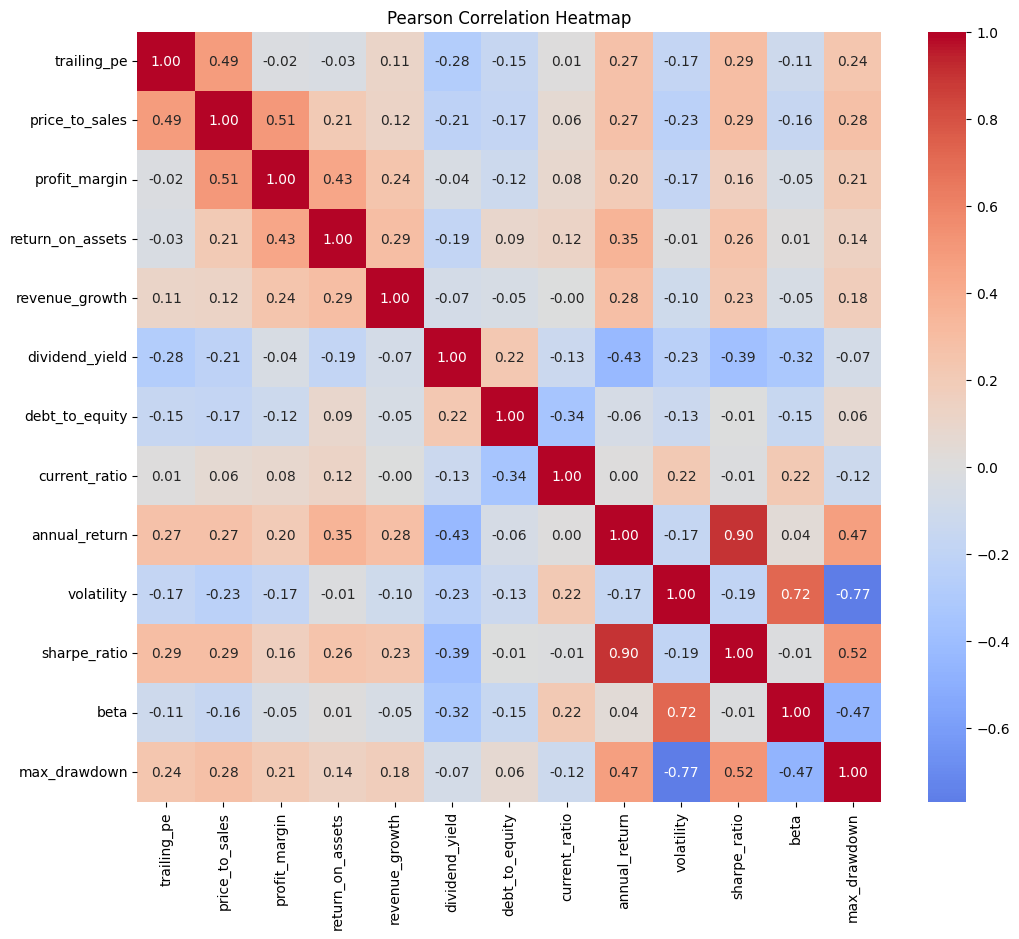

In [37]:
# Droppinng features with high correlation
#_scaled_data_neutral = _scaled_data_neutral.drop(['sharpe_ratio', 'max_drawdown','sector'], axis=1)
correlation_heatmap(final_data, final_data.columns)
#_scaled_data_neutral = _scaled_data_neutral.drop(['sharpe_ratio', 'max_drawdown','sector'], axis=1)
vars = final_data.var()            # sample variance (ddof=1) by default
#print(vars.sort_values())

# 3. Factor Mapping 

| Factor theme | Metrics we feed in | Investor question it answers |
|--------------|-------------------|------------------------------|
| **Value (Valuation Spectrum)** | • Trailing P/E<br>• Price-to-Sales (P/S) | *“How expensive or cheap is this stock relative to its sales and earnings?”* |
| **Growth (Business Momentum)** | • Revenue-growth rate<br>• Return on Assets (ROA) | *“Is the company expanding quickly and using its assets efficiently?”* |
| **Quality (Operational Strength)** | • Profit margin<br>• Return on Assets (ROA) | *“How consistently and profitably does this firm operate?”* |
| **Defensive (Balance-Sheet Resilience)** | • Current ratio<br>• Debt-to-Equity | *“Does the company have enough liquidity and low leverage to ride out a downturn?”* |
| **Momentum & Risk (Trend Stability)** | • 3-year Sharpe ratio<br>• Maximum drawdown | *“Does the price rise steadily without harsh crashes?”* |

*Note:* **ROA** is used in both *Growth* and *Quality*, as we are left that data only.  
In the Growth bucket it captures “efficient expansion,” while in the Quality bucket it signals “steady operational strength.”


# 4. Clustering



## 4.1 Why K-Means, and Why One Model per Factor?

### Why K-Means?

* **Fast & lightweight** – 500 stocks × ~20 features cluster in milliseconds; easy to refresh nightly.  
* **Transparent prototypes** – each cluster is summarised by a centroid, so you can read off the “typical” stock in that bucket.  
* **Low-maintenance** – no hyper-parameter grid or GPU; just refit when new data arrives.

---

### 🔍 Why run a *separate* K-Means for every factor family?

| Benefit | What it means in practice |
|---------|---------------------------|
| **One question at a time** | Value clustering answers **“Who’s cheapest?”** without growth or leverage muddying the waters. |
| **Natural tiers inside each factor** | K-Means carves out levels like *Deep Value → Undervalued → Fair Value → Overvalued*, giving investors a clear menu. |
| **Lego-style screens** | Independent buckets let you mix and match later—e.g. **High-Growth ∩ Prime-Quality** for a GARP screen. |
| **Less noise, fewer distance issues** | Clustering 2–3 related features at once avoids the curse of dimensionality that plagues high-D distance metrics. |

**Bottom line:**  
A simple, factor-by-factor K-Means setup keeps the model **interpretable for investors** and **flexible for custom screening**—all without heavyweight computation.
  

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import scipy.cluster.hierarchy as sch


def Knn_cluster(data, k_num = 10):
    result_metric = {}


    for k in range(2, k_num+1):
        
        kmeans = KMeans(n_clusters=k,n_init=50, random_state=42).fit(data)
        sil_score = silhouette_score(data, kmeans.labels_, metric='euclidean')
        ch_score = calinski_harabasz_score(data, kmeans.labels_)
        db_score = davies_bouldin_score(data, kmeans.labels_) 
    
        result_metric[k] = {}
 
        result_metric[k]['silhouette_score'] = sil_score
        result_metric[k]['inertia'] = kmeans.inertia_
        result_metric[k]['score'] = kmeans.score
        result_metric[k]['model'] = kmeans
        result_metric[k]['ch_score'] = ch_score
        result_metric[k]['db_score'] = db_score

        #print(kmeans.labels_)
    return result_metric, kmeans


def hdbscan(data):
    cluster = HDBSCAN(min_cluster_size=15, min_samples=10,cluster_selection_method='leaf')
    labels = cluster.fit_predict(data) 
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_frac = (labels == -1).mean()
    print(f"{n_clusters} clusters, {noise_frac:.1%} noise")
    #print("Persistence:", cluster.cluster_persistence_)   # array per cluster


    # Silhouette on core points
    #mask = labels >= 0
    #print("Silhouette (no-noise):",
    #silhouette_score(data[mask], labels[mask]))

def hierarchy(data):
    z = sch.linkage(data, method = 'ward', metric = 'euclidean')

    plt.figure(figsize=(10, 6))
    sch.dendrogram(z, truncate_mode='level', p=600)  
    # shows top 5 merges; remove truncate_mode to see all
    plt.xlabel('Stocks')
    plt.ylabel('Ward distance')
    plt.show()



In [39]:
from yellowbrick.cluster import SilhouetteVisualizer
def sil_visualizer(data, key, value, k_num = 2):
    metric, kmeans = Knn_cluster(data[value].copy(), k_num = k_num)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(data[value].copy())
    visualizer.poof()

In [40]:
def plot_cluster_evaluation(ks, sil_score, key, wcss=None, ch_score=None,  db_score=None ):
    """
    Plots clustering evaluation metrics in a reusable way.

    Parameters:
    -----------
    ks : list or array-like
    sil_score : list or array-like
    key : str
        A title identifier that appears in the plot title.
    wcss : list or array-like, optional
        Within-Cluster Sum of Squares (WCSS)/elbow values to be plotted.
        (Set to None if you don’t have these, e.g., for HDBSCAN.)
    ch_score : list or array-like, optional
        Calinski–Harabasz scores. If provided, a third axis is added.
    
    The function creates:
      - Two y-axes if wcss is provided (left for WCSS in blue and right for silhouette in red),
        and a third axis if CH score is available.
      - A single axis for silhouette if wcss is None (for example, when evaluating HDBSCAN).
    """
    fig, ax1 = plt.subplots()

    # If WCSS data is available, plot it on the primary left axis.
    if wcss is not None:
        ax1.set_xlabel('Number of clusters (k)')
        ax1.set_ylabel('WCSS', color='tab:blue')
        line1, = ax1.plot(ks, wcss, marker='o', color='tab:blue', label='WCSS (elbow)')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        
        # Plot silhouette score on a secondary right axis.
        ax2 = ax1.twinx()                                       
        ax2.set_ylabel('Silhouette score', color='tab:red')
        line2, = ax2.plot(ks, sil_score, marker='s', linestyle='--', color='tab:red',
                          label='Silhouette')
        ax2.tick_params(axis='y', labelcolor='tab:red')
    else:
        # When no WCSS is provided (e.g. for HDBSCAN), plot silhouette on the primary axis.
        ax1.set_xlabel('Parameter values')
        ax1.set_ylabel('Silhouette score', color='tab:red')
        line2, = ax1.plot(ks, sil_score, marker='s', linestyle='--', color='tab:red',
                          label='Silhouette')
        ax1.tick_params(axis='y', labelcolor='tab:red')

    # Prepare legend handles.
    lines, labels = [], []
    if wcss is not None:
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        lines.extend(lines1 + lines2)
        labels.extend(labels1 + labels2)
    else:
        lines, labels = ax1.get_legend_handles_labels()

    # Optionally plot Calinski–Harabasz if provided.
    if ch_score is not None:
        ax3 = ax1.twinx()
        # Move the third axis to avoid overlap with the second.
        ax3.spines['right'].set_position(('outward', 60))  
        ax3.set_ylabel('Calinski–Harabasz score', color='tab:green')
        line3, = ax3.plot(ks, ch_score, marker='^', linestyle='-.', color='tab:green',
                          label='CH Score')
        ax3.tick_params(axis='y', labelcolor='tab:green')
        lines.append(line3)
        labels.append('CH Score')
    
    # Combine legends from all active axes.
    ax1.legend(lines, labels, loc='best')
    
    if db_score is not None:
        ax4 = ax1.twinx()   
        ax4.spines['right'].set_position(('outward', 120))
        ax4.set_ylabel('Davies–Bouldin (lower better)', color='tab:purple')
        line4, = ax4.plot(ks, db_score, marker='v', linestyle=':',
                          color='tab:purple', label='DB')
        ax4.tick_params(axis='y', labelcolor='tab:purple')
        lines.append(line4)
        labels.append('DB')

    plt.title(f'Elbow vs. Silhouette vs. DB for {key}')
    plt.xticks(ks)
    plt.tight_layout()
    plt.show()

In [41]:
final_data

trailing_pe  price_to_sales  profit_margin  return_on_assets  \
0        -0.4345          0.0621         0.4553           -0.2431   
1        -0.5822         -0.1954         0.1236            0.9407   
2        -0.6160          0.3847         1.5858            0.0000   
3         1.1980          0.3972        -0.1494            0.7687   
4        -0.2698         -0.5847        -0.4470            0.6028   
..           ...             ...            ...               ...   
496       0.4352          0.1082        -0.2646           -0.5634   
497       0.6709          1.0144         1.4477            1.4042   
498      -0.3410         -0.6865        -0.5177           -0.1404   
499      -0.2318         -0.1299         0.1332           -0.3128   
500       0.0990          0.5825         1.2088            2.1565   

     revenue_growth  dividend_yield  debt_to_equity  current_ratio  \
0           -0.2308          0.9142          1.9083         0.1378   
1           -1.0895          0.4889         -2.0598         0.3240   
2           -0.2348          0.5874         -0.8885         0.0000   
3           -0.0259          1.2948          3.8902        -1.3860   
4           -0.3249          0.6364         -0.4144         0.0871   
..              ...             ...             ...            ...   
496          0.4273         -0.0391         -1.3997         0.5588   
497          1.0903          0.2902          0.0000         0.1992   
498          1.5615         -0.4037          0.2238         0.0502   
499         -0.1954          0.2080         -0.3552         0.5329   
500         -0.1430          0.3039          0.7306         0.3889   

     annual_return  volatility  sharpe_ratio    beta  max_drawdown  
0          -0.0508      0.3874       -0.1410 -0.6667       -0.6645  
1          -0.3151      0.0000       -0.3877 -0.3784       -0.2415  
2           0.7043     -0.9371        0.8261 -0.2432        0.6822  
3           0.7634     -0.7134        0.8913 -0.8378        1.0521  
4          -0.4816     -0.6763       -0.6386 -0.4494        0.5424  
..             ...         ...           ...     ...           ...  
496         0.1971     -0.2213        0.1762  0.0901        0.1737  
497         0.1227     -1.5190        0.2342 -1.0602        1.5289  
498        -1.4211      0.3893       -1.0964  0.5169       -0.5721  
499        -0.1395     -0.6092       -0.2391  0.1622        0.2542  
500        -0.0693     -0.1548       -0.0217  0.3514        0.3672  

[501 rows x 13 columns]

Value ['trailing_pe', 'price_to_sales']


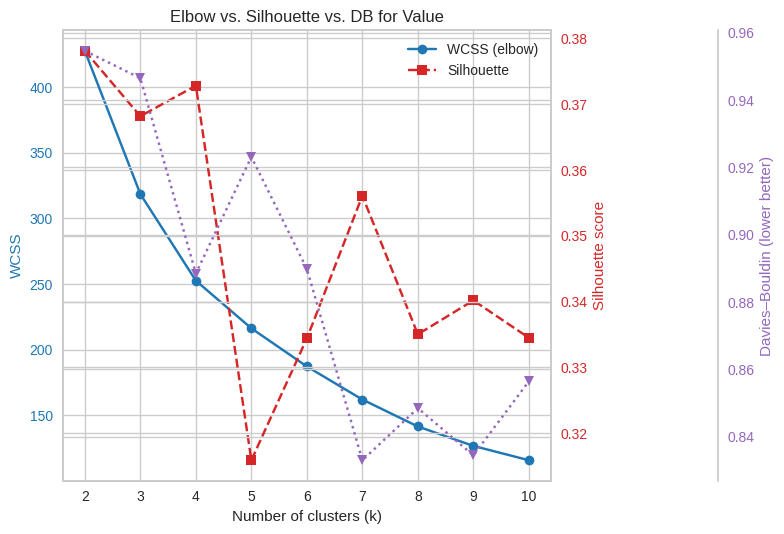

Growth ['revenue_growth', 'return_on_assets']


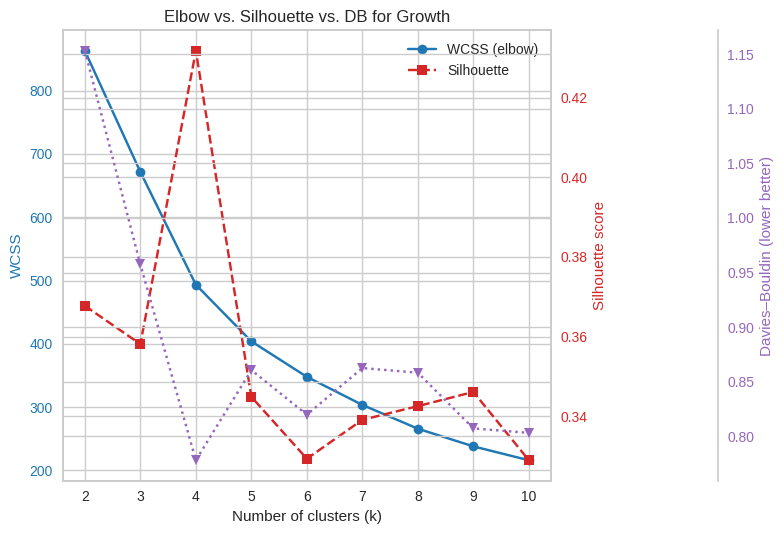

Quality ['profit_margin', 'return_on_assets']


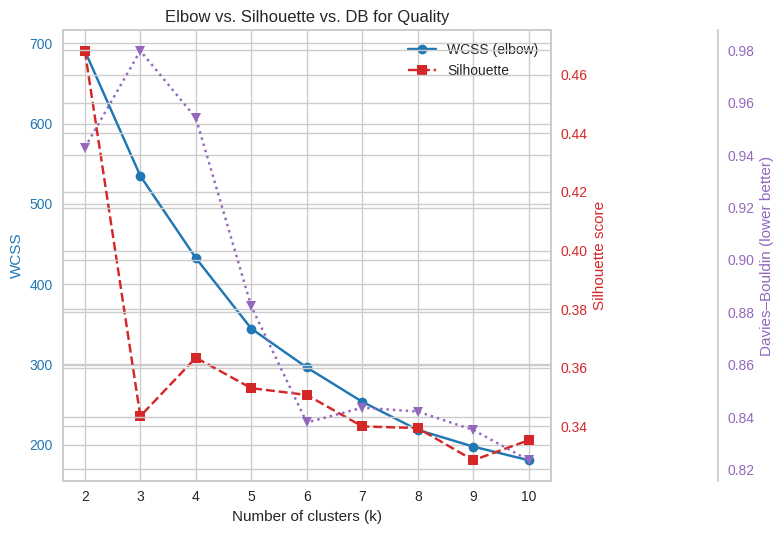

Defensive ['current_ratio', 'debt_to_equity']


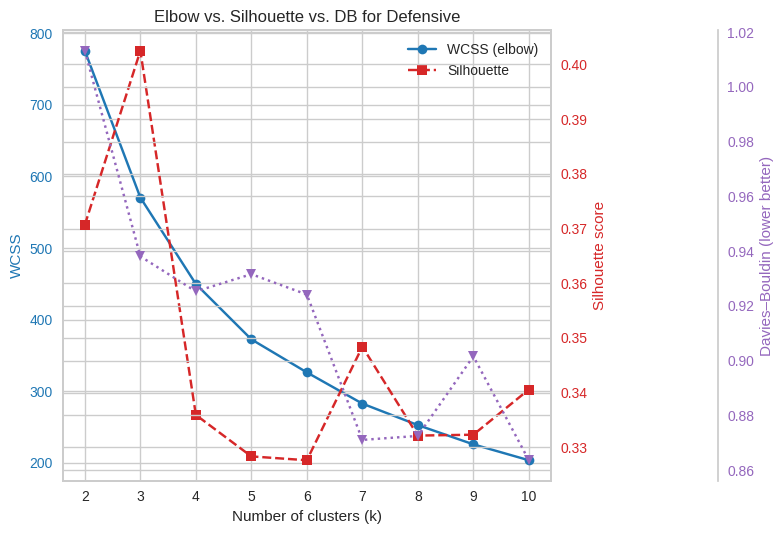

Risk_Momentum ['sharpe_ratio', 'max_drawdown']


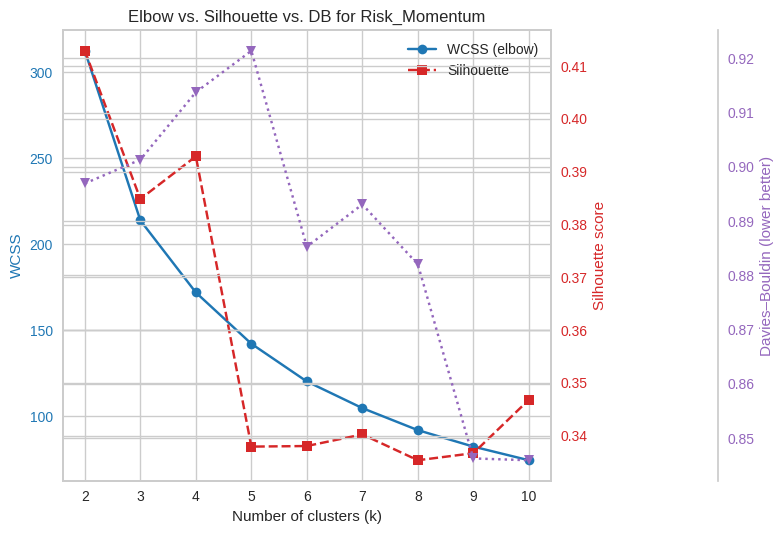

In [42]:
bucket = {
    'Value': ['trailing_pe', 'price_to_sales'],
    'Growth': ['revenue_growth','return_on_assets'],
    'Quality': ['profit_margin','return_on_assets'],
    'Defensive': ['current_ratio','debt_to_equity'],
    'Risk_Momentum':  ['sharpe_ratio','max_drawdown']
}

k_means_obj = {}

for key, value in bucket.items():
    print(key, value)   
    metric, kmeans = Knn_cluster(X_clipped[value].copy(), k_num = 10)
    #hdbscan(final_data[value])
    k_means_obj[key] = kmeans   
    ks        = sorted(metric.keys())
    wcss      = [metric[k]['inertia']     for k in ks]
    sil_score = [metric[k]['silhouette_score']  for k in ks]
    ch_score =  [metric[k]['ch_score'] for k in ks]
    db_score = [metric[k]['db_score'] for k in ks]
    

    plot_cluster_evaluation(ks=ks, wcss= wcss, sil_score= sil_score, key= key, db_score= db_score)
    

## 4.2 Chosen *k* for Each Factor Family
> - **Choosing *k*** – we combine three independent diagnostics:  
> - **Elbow (WCSS)** – find the bend where adding clusters yields diminishing WCSS improvement.  
> - **Silhouette score** – ranges –1 → +1; values > 0.3 already signal useful separation for noisy financial data.  
> - **Davies–Bouldin index** – lower is better; values < 1 are usually acceptable.  

| Factor bucket | k | Why this k? — visual cues from the “Elbow - Silhouette - Davies-Bouldin” chart |
|---------------|---|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Value** | **4** | WCSS elbow at k = 4, Silhouette local high ≈ 0.37, DB trough ≈ 0.89, and bootstrap ARI 0.81 ± 0.13 validates four clusters give the best mix of separation and stability. |
| **Growth** | **2** | Internal metrics favour k ≈ 4 (Silhouette peak ≈ 0.43, DB trough ≈ 0.79), yet bootstrap stability is weaker (median ARI ≈ 0.58 ) and the four-way split offers no clear factor story. We therefore keep the simpler, more reproducible two-cluster solution.|
| **Quality** | **3** | Internal metrics favour k ≈ 3 (Silhouette local high ≈ 0.38, DB dip ≈ 0.86). Bootstrap ARI is bimodal—median ≈ 0.79 but a left-tail down to 0.2—so clusters are solid in most resamples yet occasionally reshuffle. We keep k = 3 as the best trade-off between cohesion and acceptable stability. |
 **Defensive** | **3** | WCSS elbow at k = 3, Silhouette bump ≈ 0.40, DB dip ≈ 0.87; bootstrap ARI 0.87 ± 0.18 (most runs > 0.75) → three clusters balance cohesion with solid repeatability. |
| **Risk & Momentum** | **3** | WCSS bend near k = 3, Silhouette plateau ≈ 0.34, DB trough ≈ 0.86; bootstrap ARI 0.94 ± 0.08 — clusters are exceptionally stable, so k = 3 is the clear choice. |

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


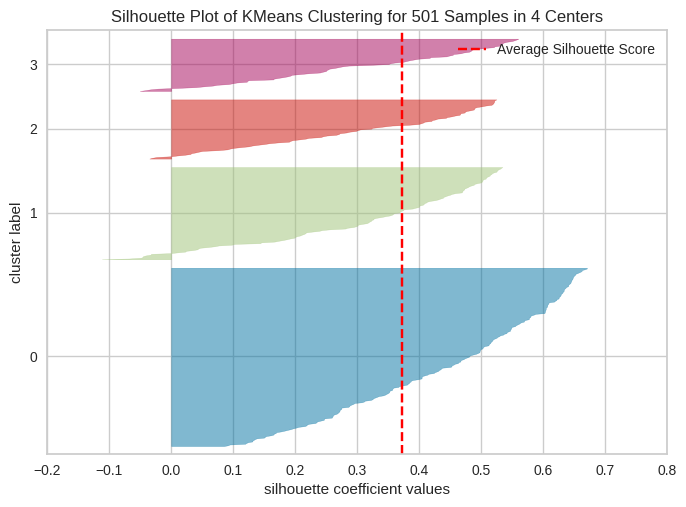

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


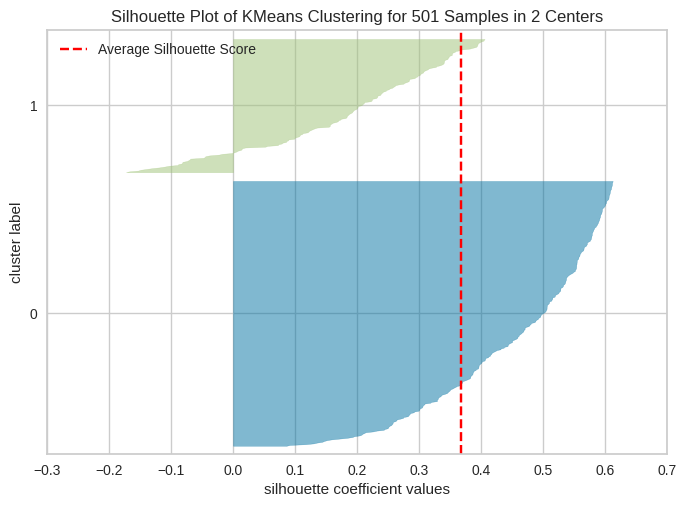

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


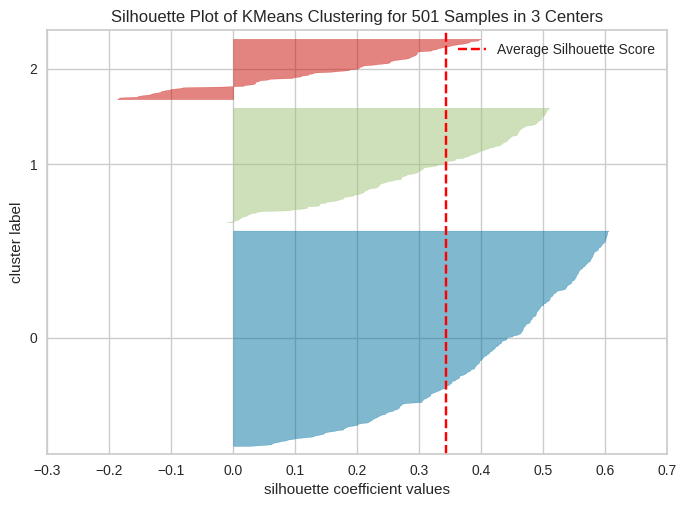

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


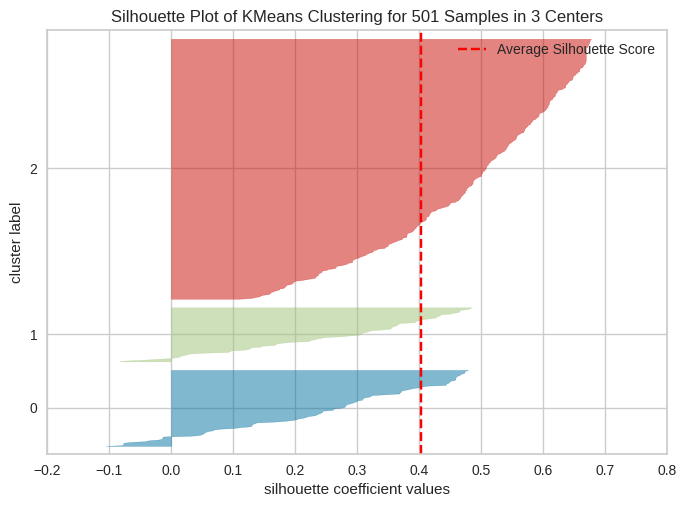

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


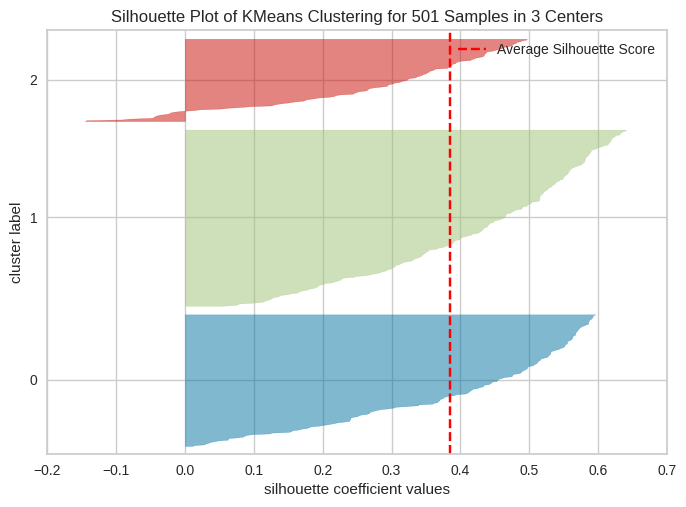

In [43]:
k_value = { 'Value': 4, 'Growth': 2, 'Quality': 3, 'Defensive': 3, 'Risk_Momentum': 3 }

for key, value in bucket.items(): 
    sil_visualizer(X_clipped, key, value, k_num= k_value[key])

In [44]:
def final_label_centroid(data,value, k_num = 2):
    kmeans = KMeans(n_clusters= k_num,n_init=50, random_state=42).fit(data[value].copy())
    labels = kmeans.labels_
    centroid = kmeans.cluster_centers_

    return labels, centroid , kmeans

In [45]:
# Optimal k value 3 for each bucket
labels = {}
centroid = {}
kmeans = {}
for key, value in bucket.items():
    print(key, value)
    labels_, centroid_, kmeans_ = final_label_centroid(X_clipped,value, k_num = k_value[key])
    labels[key] = labels_
    centroid[key] = centroid_
    kmeans[key] = kmeans_
    #print(labels[key])

Value ['trailing_pe', 'price_to_sales']
Growth ['revenue_growth', 'return_on_assets']
Quality ['profit_margin', 'return_on_assets']
Defensive ['current_ratio', 'debt_to_equity']
Risk_Momentum ['sharpe_ratio', 'max_drawdown']


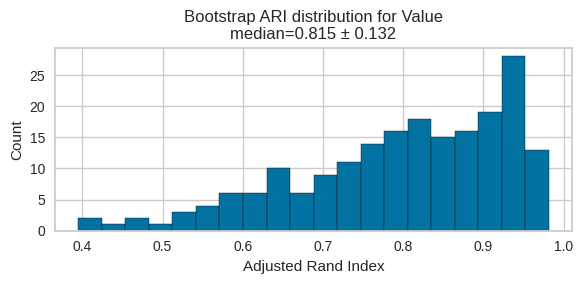

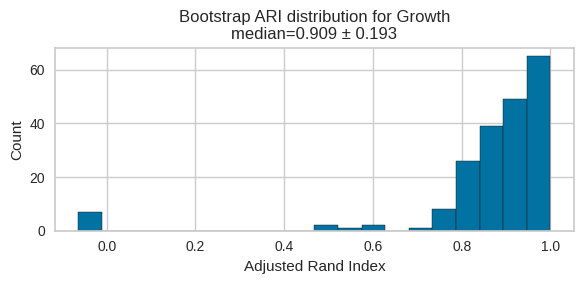

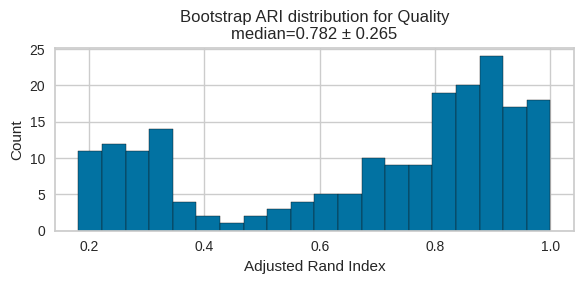

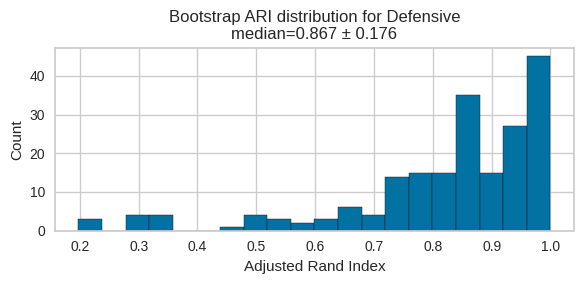

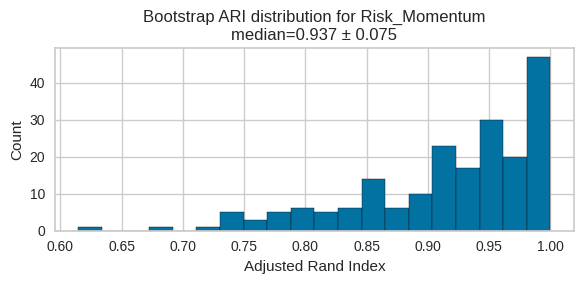

In [46]:
# ARI test Cluster Roboustness
from sklearn.metrics import adjusted_rand_score
results = {}
# assuming my final_data.index as stock id

for key, value in bucket.items():
    aris = []
    base_labels = pd.Series(labels[key], index=X_clipped.index, name = 'baseline_labels')
    for b in range(200):
        sample = X_clipped[value].sample(frac=1, replace=True, random_state=b)
        km = KMeans(n_clusters= k_value[key] ,n_init=50, random_state=42).fit(sample)
        label_b = km.labels_
        #print(label_b)
        
        ari = adjusted_rand_score(base_labels.loc[sample.index], label_b)
        aris.append(ari)
        
    results[key] = {
        'Ari_mean': np.mean(aris),
        'Ari_std': np.std(aris),
        'Ari_median': np.median(aris)
    }
     # 4) Quick histogram of ARI
    plt.figure(figsize=(6,3))
    plt.hist(aris, bins=20, edgecolor='k')
    plt.title(f'Bootstrap ARI distribution for {key}\n'
            f'median={results[key]["Ari_median"]:.3f} ± {results[key]["Ari_std"]:.3f}')

    plt.xlabel('Adjusted Rand Index')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

## 4.3. Centroids for each buckets - Z Space 

In [47]:
centroid

{'Value': array([[-0.05650853,  0.09350058],
        [ 1.03279718,  0.77717424],
        [-0.01319875, -1.14199491],
        [-1.45881155, -0.77201492]]),
 'Growth': array([[-0.37462503, -0.26507796],
        [ 1.01154503,  0.90015423]]),
 'Quality': array([[ 0.21620927,  0.14760998],
        [-0.85212332, -0.70246824],
        [ 1.64196272,  1.60868499]]),
 'Defensive': array([[ 1.17230251, -1.50362961],
        [-0.4325758 ,  1.93538934],
        [-0.15163399,  0.03786865]]),
 'Risk_Momentum': array([[-0.50554277, -0.79946502],
        [ 0.08240124,  0.23349417],
        [ 1.33565038,  0.64881497]])}

### **Value** *(Trailing P/E & Price-to-Sales)*

| Cl. | Trailing P/E (z) | P/S (z) | What those numbers mean | Suggested Label |
|:--:|:----------------|:-------|-------------------------|-----------------|
| 0 | –0.06 *(≈ median)* | +0.09 *(≈ median)* | Both ratios near peer median  | **Fair Value** |
| 1 | +1.03 *(well above)* | +0.78 *(well above)* | High P/E and high P/S expensive vs peers | **Overvalued** |
| 2 | –0.01 *(≈ median)* | –1.14 *(well below)* | Very cheap on P/S while P/E is average | **Moderately Undervalued** |
| 3 | –1.46 *(far below)* | –0.77 *(well below)* | Very cheap on both metrics | **Deep Undervalued** |

---

### **Growth** *(Revenue Growth & ROA)*

| Cl. | Rev Growth (z) | ROA (z) | What those numbers mean | Label |
|:--:|:--------------|:-------|-------------------------|-------|
| 0 | –0.37 *(below median)* | –0.27 *(below median)* | Slow revenue growth + weak asset returns | **Low Growth** |
| 1 | +1.01 *(well above)* | +0.90 *(well above)* | Fast growth and efficient asset use | **High Growth** |

---

### **Quality** *(Profit Margin & ROA)*

| Cl. | Profit Margin (z) | ROA (z) | What those numbers mean | Label |
|:--:|:-----------------|:-------|-------------------------|-------|
| 0 | +0.22 *(slightly above)* | +0.15 *(slightly above)* | Margins and returns just above peers | **Average Quality** |
| 1 | –0.85 *(well below)* | –0.70 *(well below)* | Weak margins and asset returns | **Low Quality** |
| 2 | +1.64 *(far above)* | +1.61 *(far above)* | Strong margins and returns | **High Quality** |

---

### **Defensive** *(Current Ratio & Debt-to-Equity)*

| Cl. | Current Ratio (z) | Debt/Equity (z) | What those numbers mean | Label |
|:--:|:-----------------|:---------------|-------------------------|-------|
| 0 | +1.17 *(well above)* | –1.50 *(well below)* | High liquidity + low leverage | **High Defense** |
| 1 | –0.43 *(below median)* | +1.94 *(far above)* | Low liquidity + high leverage | **Low Defense** |
| 2 | –0.15 *(≈ median)* | +0.04 *(≈ median)* | Near-median on both metrics | **Average Defense** |

---

### **Risk & Momentum** *(Sharpe Ratio & Max Drawdown)*

| Cl. | Sharpe (z) | Max Drawdown (z) | What those numbers mean | Label |
|:--:|:----------|:----------------|-------------------------|-------|
| 0 | –0.51 *(below)* | –0.80 *(better drawdown)* | Low Sharpe, shallow drawdowns → sluggish | **Low Momentum** |
| 1 | +0.08 *(≈ median)* | +0.23 *(≈ median)* | Near-median risk–return | **Average Momentum** |
| 2 | +1.34 *(well above)* | +0.65 *(worse drawdown)* | High Sharpe, stronger but more volatile trend | **High Momentum** |


In [48]:
for key, value in bucket.items():
    X_clipped[key] = labels[key]
    clean_data[key] = labels[key]


In [49]:
for key, value in bucket.items():
    print(clean_data[[value[0],value[1],f'{key}']].groupby(f'{key}').median())

       trailing_pe  price_to_sales
Value                             
0          21.4096          3.2107
1          39.2987          6.5069
2          20.3251          0.9304
3          11.6358          1.0848
        revenue_growth  return_on_assets
Growth                                  
0               0.0250            0.0445
1               0.1300            0.0858
         profit_margin  return_on_assets
Quality                                 
0               0.1442            0.0641
1               0.0477            0.0291
2               0.2782            0.1355
           current_ratio  debt_to_equity
Defensive                               
0                 2.4345         19.6930
1                 1.0065        310.5695
2                 1.1285         75.6290
               sharpe_ratio  max_drawdown
Risk_Momentum                            
0                   -0.3100       -0.5000
1                    0.0200       -0.3200
2                    0.5900       -0.2500


In [50]:
clean_data['ticker'] = merged_df['ticker']

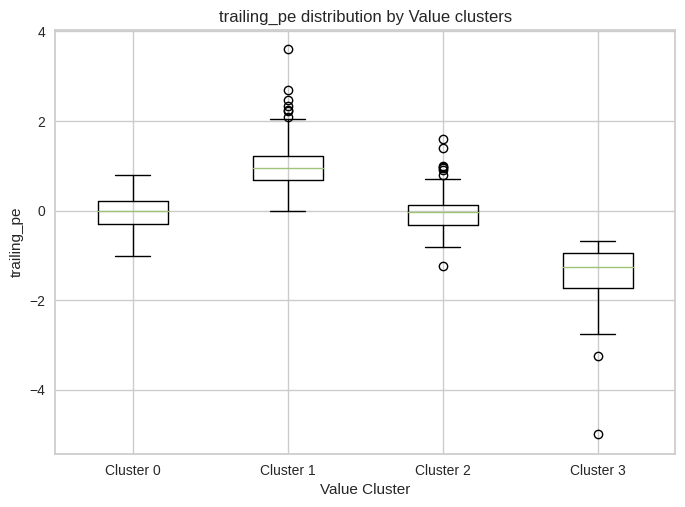

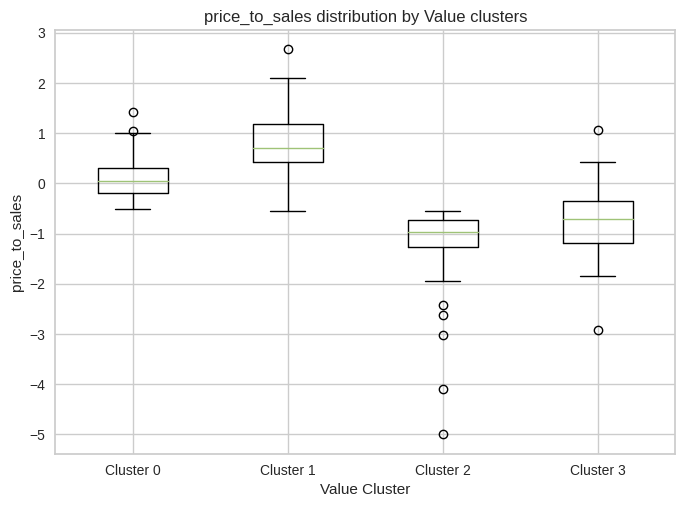

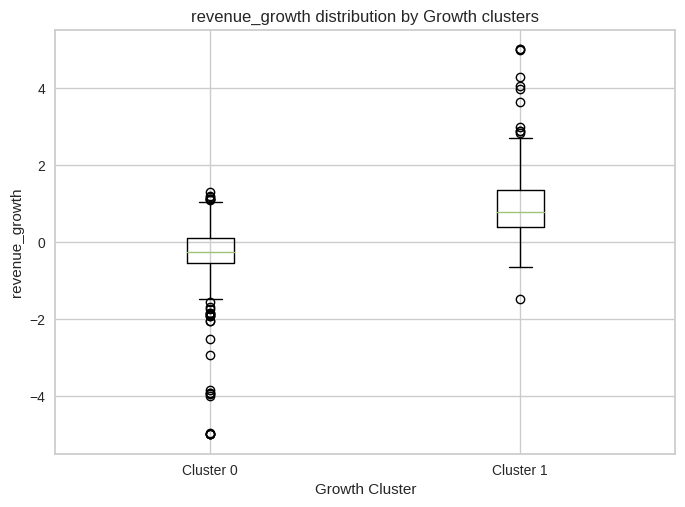

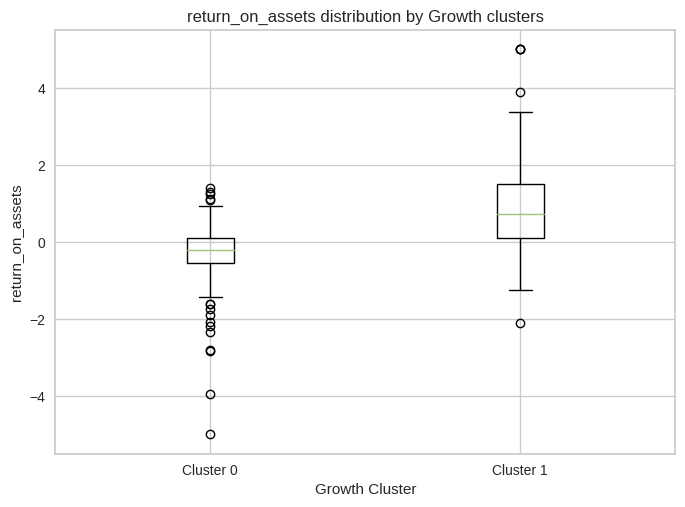

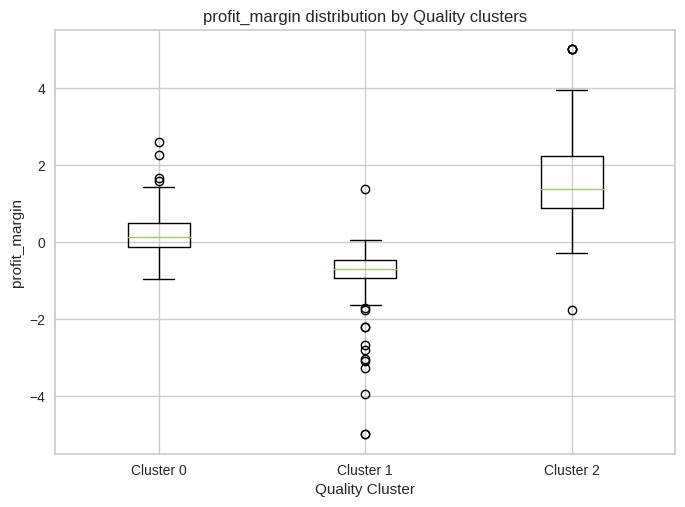

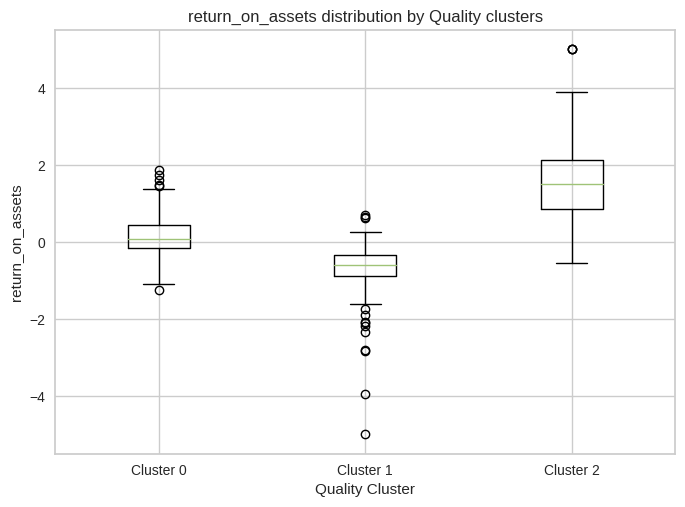

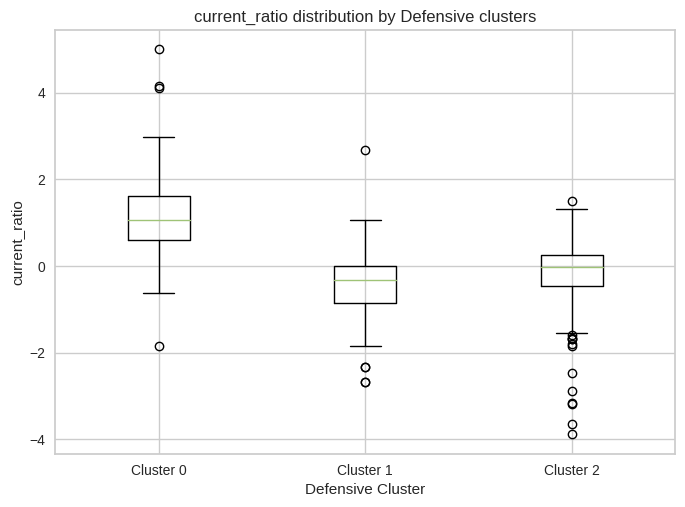

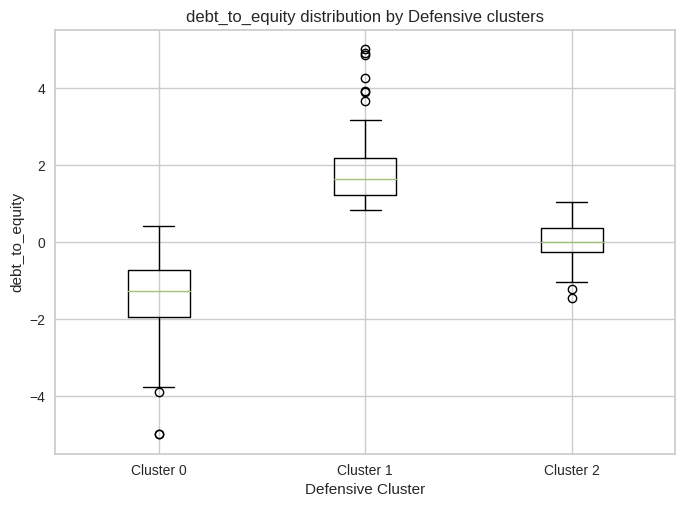

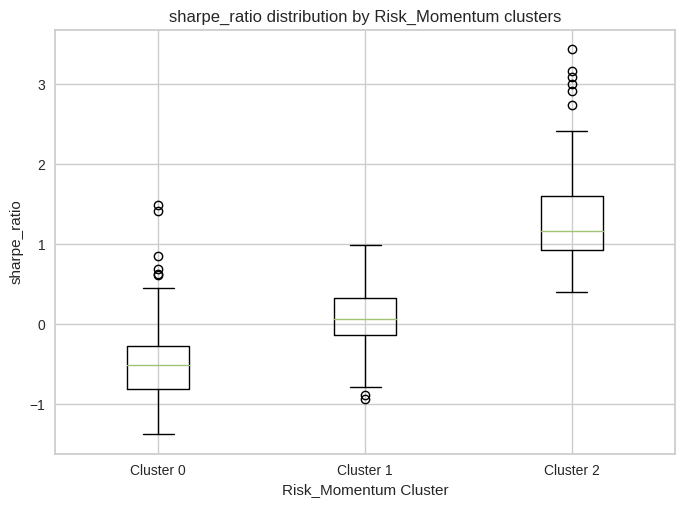

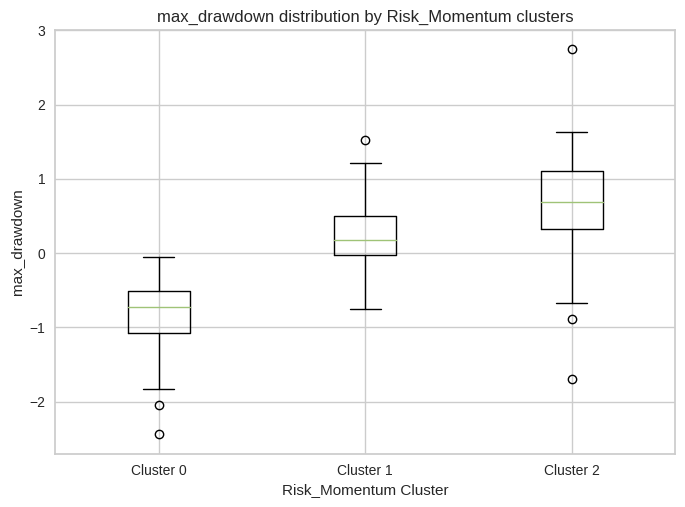

In [51]:
# Box plot 
for theme, feats in bucket.items():
    for feat in feats:
        # Prepare the data for boxplot: list of arrays, one per cluster label
        data = X_clipped[[feat, theme]].dropna()
        cluster_labels = sorted(data[theme].unique())
        groups = [data[data[theme] == label][feat].values for label in cluster_labels]
        
        # Plot
        plt.figure()
        plt.boxplot(groups, labels=[f"Cluster {l}" for l in cluster_labels])
        plt.title(f"{feat} distribution by {theme} clusters")
        plt.xlabel(f"{theme} Cluster")
        plt.ylabel(feat)
        plt.show()

## 4.4. Cluster Labels

In [52]:
bucket_label_map = {
    "Value": {
        0: "Fair Value",
        1: "Overvalued",
        2: "Undervalued",
        3: "Undervalued"      # deep-value vs moderate both mapped to one label
    },
     "Growth": {
        0: "Low Growth",
        1: "High Growth"
    },
   "Quality": {
        0: "Average Quality",
        1: "Low Quality",
        2: "High Quality"
    },

    'Defensive': {0:'High Defense',
                  1:'Low Defense', 
                  2:'Average Defense'
    },
    "Risk_Momentum": {
        0: "Low Momentum",
        1: "Average Momentum",
        2: "High Momentum"
    }
}

> * Note : Our Value groups are built relative to each stock’s sector. We first neutralize P/E and P/S by subtracting the sector median and scaling by the IQR, so a z-score below zero means “cheaper  than your sector peers.” For example, Accenture (ACN) has z-scores of –0.27 on P/E and –0.58 on P/S—making it “Undervalued” in the Technology bucket—even though its raw P/E (~23×) is near the market median.

If you prefer an absolute/global view, we also provide a “Fair Value” label based on distance to the real-unit centroids across the whole universe.

In [53]:
for key, value in bucket.items():
    clean_data[f'{key}'] = clean_data[f'{key}'].map(bucket_label_map[key])
    X_clipped[f'{key}'] = X_clipped[f'{key}'].map(bucket_label_map[key])
    

## 4.5 Cluster Plots

In [54]:
def _final_kmeans_plot(data, key, value,bucket_label_map, k_num = 2):
    kmeans = KMeans(n_clusters= k_num,n_init=50, random_state=42).fit(data[value].copy())
    labels = kmeans.labels_
    centroid = kmeans.cluster_centers_

    # Scatter plot in z-space
    plt.figure(figsize=(7,7))
    scat = plt.scatter(
       x = data[value[0]], y = data[value[1]],
        c=labels, cmap='tab10', s=50, alpha=0.7, edgecolor='k'
    )
    handles, _ = scat.legend_elements()
    plt.legend(handles, [str(i) for i in range(k_num)],
               title="Cluster ID", loc="best")
    
    # Plot centroids
    cent = plt.scatter(
        centroid[:,0], centroid[:,1],
     c='black', s=200, marker='X', label='Centroids'
    )

    names = [bucket_label_map[key][i] for i in range(k_num)]
    labels_list = names + ['Centroids']
    handles_list = list(handles) + [cent]

   
    cent_handle, _ = cent.legend_elements()
    plt.xlabel(f'{value[0]} (z)')    
    plt.ylabel(f'{value[1]} (z)')    
    plt.title('Clusters in Z-Space')
    plt.legend(handles_list, labels_list, loc='best')
    plt.grid(alpha=0.3)
    plt.show()

    return labels, centroid

Value ['trailing_pe', 'price_to_sales']


/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


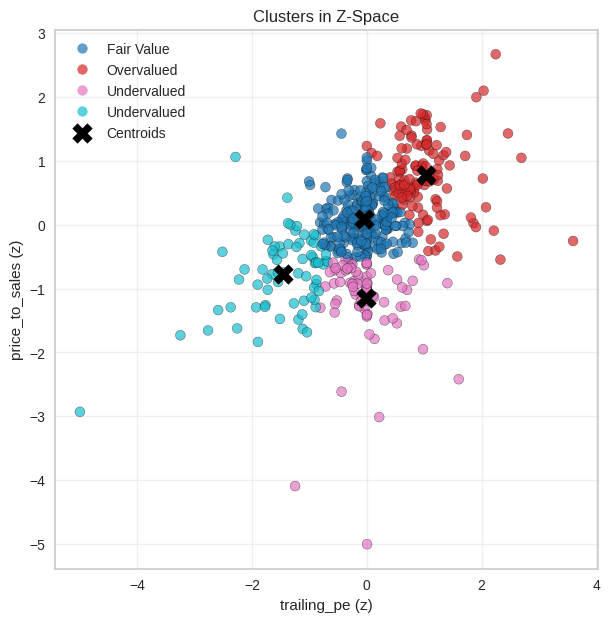

Growth ['revenue_growth', 'return_on_assets']


/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


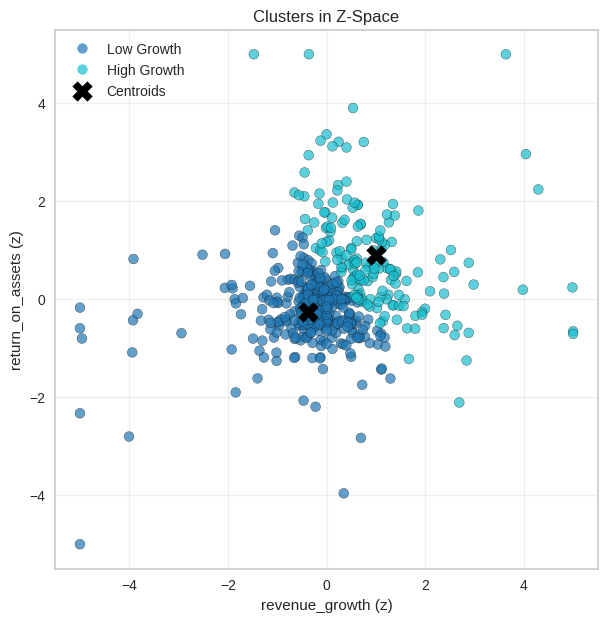

Quality ['profit_margin', 'return_on_assets']


/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


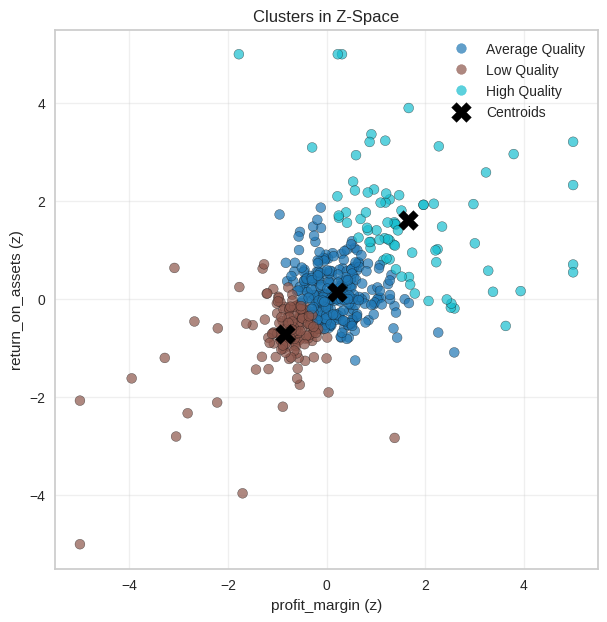

Defensive ['current_ratio', 'debt_to_equity']


/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


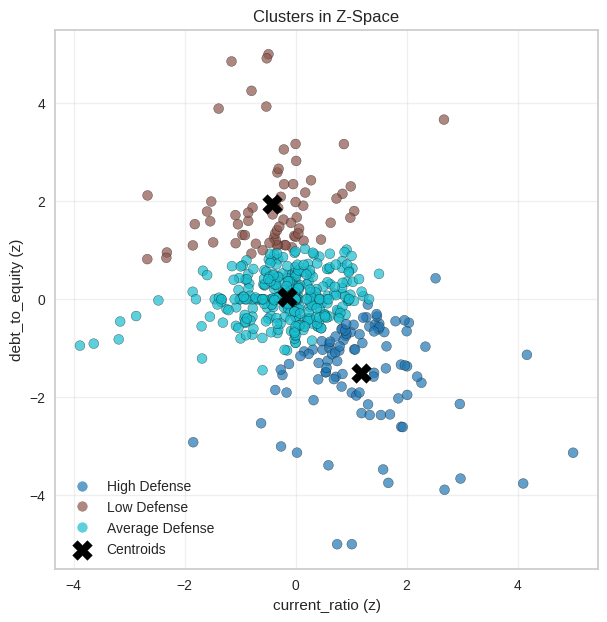

Risk_Momentum ['sharpe_ratio', 'max_drawdown']


/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


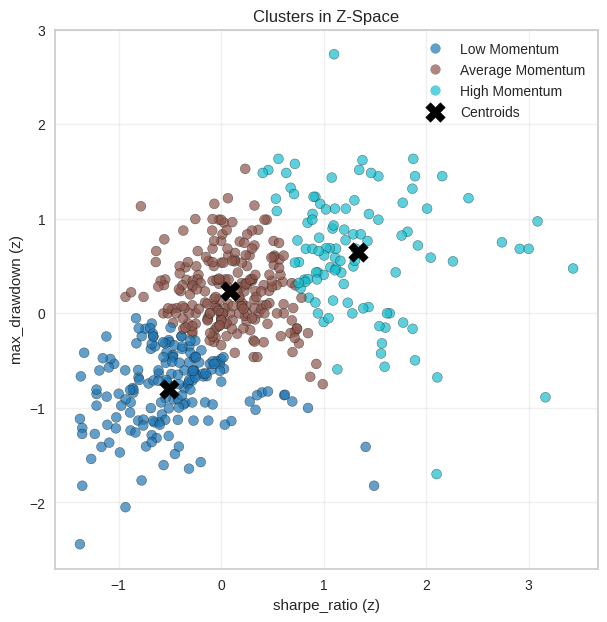

In [55]:
for key, value in bucket.items():
    print(key, value)
    labels_, centroid_= _final_kmeans_plot(X_clipped, key, value, bucket_label_map, k_num = k_value[key])

# Portfolio Back-Test

## 5.1 Hypothetical investor personas  

| Strategy name | Cluster rule | Intuitive story |
|---------------|--------------|-----------------|
| **Value-Seeker** | Hold stocks in the **“Undervalued”** cluster(s) of the Value bucket (e.g. clusters 0 & 1 where P/E and P/S are lowest). | Classic bargain hunting: buy the cheapest quartile and ignore the rest. |
| **Growth-Chaser** | Hold stocks in the **“High-Growth”** cluster of the Growth bucket (cluster 1 in our k = 2 split). | Bet that firms with double-digit revenue growth and high ROA will keep re-rating upward. |
| **Composite** | Intersection of three “top” clusters:<br> · Growth = High Growth (cluster 1)<br> · Risk/Momentum = High Sharpe / low draw-down (cluster 0)<br> · Quality = High Margin & ROA (cluster 1) | Concentrated sleeve that demands **growth + momentum + quality** in one package. Think of it as a “best-of-everything” basket. |



In [56]:
clean_data

trailing_pe  forward_pe  price_to_book  price_to_sales  profit_margin  \
0        18.6873     17.1734        19.0494          3.0747         0.1698   
1        17.3650     15.4877         4.8299          2.4245         0.1398   
2        17.2094     25.4806         4.7769          5.4303         0.3189   
3        72.8015     14.2842        91.9679          5.5314         0.0759   
4        23.3515     20.1151         6.0622          2.6652         0.1143   
..           ...         ...            ...             ...            ...   
496      30.3795     23.3442         2.5318          3.2068         0.1040   
497      27.4761     23.6349        -5.2422          5.4074         0.1968   
498      22.1475     14.0424         3.2351          2.3645         0.1060   
499      21.8335     11.2468         1.5445          2.5374         0.1177   
500      27.3773     23.5773        14.0542          7.2929         0.2686   

     return_on_equity  return_on_assets  revenue_growth  eps_growth  \
0              0.9185            0.0593          0.0010     -0.2300   
1              0.2863            0.1353         -0.0770     -0.2010   
2              0.1285            0.0568          0.0400      0.0820   
3              0.6229            0.0849          0.0560         NaN   
4              0.2697            0.1158          0.0540      0.0680   
..                ...               ...             ...         ...   
496            0.0845            0.0430          0.0650      0.2260   
497            0.3169            0.2449          0.1600     -0.0860   
498            0.1595            0.0626          0.3220      8.5880   
499            0.0725            0.0465          0.0430     -0.4290   
500            0.5114            0.1487          0.0470      0.1070   

     dividend_yield  ...  sharpe_ratio   beta  max_drawdown  \
0            0.0286  ...        0.0700 0.8000       -0.4000   
1            0.0211  ...       -0.0700 0.8800       -0.3400   
2            0.0176  ...        0.0700 0.6100       -0.2500   
3            0.0370  ...        0.1000 0.3900       -0.2000   
4            0.0205  ...       -0.2100 1.0400       -0.2900   
..              ...  ...           ...    ...           ...   
496          0.0133  ...        0.2500 1.0100       -0.2900   
497          0.0194  ...        0.1200 0.6400       -0.1800   
498          0.0000  ...       -0.4000 1.4700       -0.5100   
499          0.0100  ...       -0.4200 0.7600       -0.3200   
500          0.0118  ...       -0.3200 0.8300       -0.3000   

                sector        Value       Growth          Quality  \
0          Industrials   Fair Value   Low Growth  Average Quality   
1          Industrials   Fair Value   Low Growth  Average Quality   
2           Healthcare   Fair Value   Low Growth  Average Quality   
3           Healthcare   Overvalued  High Growth  Average Quality   
4           Technology  Undervalued   Low Growth  Average Quality   
..                 ...          ...          ...              ...   
496        Industrials   Fair Value   Low Growth      Low Quality   
497  Consumer Cyclical   Overvalued  High Growth     High Quality   
498         Technology  Undervalued  High Growth      Low Quality   
499         Healthcare   Fair Value   Low Growth  Average Quality   
500         Healthcare   Fair Value  High Growth     High Quality   

           Defensive     Risk_Momentum ticker  
0        Low Defense      Low Momentum    MMM  
1       High Defense      Low Momentum    AOS  
2    Average Defense     High Momentum    ABT  
3        Low Defense     High Momentum   ABBV  
4    Average Defense  Average Momentum    ACN  
..               ...               ...    ...  
496     High Defense  Average Momentum    XYL  
497  Average Defense  Average Momentum    YUM  
498  Average Defense      Low Momentum   ZBRA  
499  Average Defense  Average Momentum    ZBH  
500  Average Defense  Average Momentum    ZTS  

[501 rows x 26 columns]

In [57]:
mask = X_clipped[X_clipped['Value'] == 'Fair Value'].copy()
cent_under = mask[bucket['Value']].mean().values
display(mask)
#cent_under

trailing_pe  price_to_sales  profit_margin  return_on_assets  \
0        -0.4345          0.0621         0.4553           -0.2431   
1        -0.5822         -0.1954         0.1236            0.9407   
2        -0.6160          0.3847         1.5858            0.0000   
5        -0.2910          0.2343         1.2792            1.2010   
8        -0.2090          0.0954         0.5214            0.2993   
..           ...             ...            ...               ...   
494      -0.1659         -0.4282        -0.3569           -0.3463   
495      -0.2415          0.0941         0.0418           -1.9010   
496       0.4352          0.1082        -0.2646           -0.5634   
499      -0.2318         -0.1299         0.1332           -0.3128   
500       0.0990          0.5825         1.2088            2.1565   

     revenue_growth  dividend_yield  debt_to_equity  current_ratio  \
0           -0.2308          0.9142          1.9083         0.1378   
1           -1.0895          0.4889         -2.0598         0.3240   
2           -0.2348          0.5874         -0.8885         0.0000   
5            0.0530         -0.4037          0.0267        -0.1786   
8            2.9825          0.0675         -0.4981         1.5074   
..              ...             ...             ...            ...   
494         -0.3504          0.0533          0.0000         0.5924   
495         -1.8417          0.0460         -0.0972        -0.1322   
496          0.4273         -0.0391         -1.3997         0.5588   
499         -0.1954          0.2080         -0.3552         0.5329   
500         -0.1430          0.3039          0.7306         0.3889   

     annual_return  volatility  sharpe_ratio    beta  max_drawdown  \
0          -0.0508      0.3874       -0.1410 -0.6667       -0.6645   
1          -0.3151      0.0000       -0.3877 -0.3784       -0.2415   
2           0.7043     -0.9371        0.8261 -0.2432        0.6822   
5          -0.7150      0.1486       -0.6867  0.1348       -0.3760   
8           0.8835     -0.7932        1.2000 -0.6374        0.8851   
..             ...         ...           ...     ...           ...   
494        -0.1276      0.4182       -0.1081  0.6265       -0.2093   
495        -0.4436      0.1722       -0.4068 -0.3590       -0.5226   
496         0.1971     -0.2213        0.1762  0.0901        0.1737   
499        -0.1395     -0.6092       -0.2391  0.1622        0.2542   
500        -0.0693     -0.1548       -0.0217  0.3514        0.3672   

          Value       Growth          Quality        Defensive  \
0    Fair Value   Low Growth  Average Quality      Low Defense   
1    Fair Value   Low Growth  Average Quality     High Defense   
2    Fair Value   Low Growth  Average Quality  Average Defense   
5    Fair Value  High Growth     High Quality  Average Defense   
8    Fair Value  High Growth  Average Quality     High Defense   
..          ...          ...              ...              ...   
494  Fair Value   Low Growth      Low Quality  Average Defense   
495  Fair Value   Low Growth      Low Quality  Average Defense   
496  Fair Value   Low Growth      Low Quality     High Defense   
499  Fair Value   Low Growth  Average Quality  Average Defense   
500  Fair Value  High Growth     High Quality  Average Defense   

        Risk_Momentum  
0        Low Momentum  
1        Low Momentum  
2       High Momentum  
5        Low Momentum  
8       High Momentum  
..                ...  
494  Average Momentum  
495      Low Momentum  
496  Average Momentum  
499  Average Momentum  
500  Average Momentum  

[233 rows x 18 columns]

## 5.2. Ranking Stock (Centroid Distance)

In [58]:
def centroid_distance(df, key, feature, label):
        mask_= df[df[key] == label]
        centroid_ = mask_[feature].mean().values
        #display(mask_)
        #print(centroid_)
        #print(mask_[feature].values - centroid_)
        dis = np.linalg.norm(mask_[feature].values - centroid_, axis=1)  
        return dis

In [59]:
ranked_data = X_clipped.copy()
ranked_data['stock_id'] = merged_df['stock_id']

In [60]:
for key, feature in bucket.items():
    dist_col = f'{key}_distance'
    ranked_data[dist_col] = np.nan
    for label in X_clipped[key].unique():
        mask = ranked_data[key] == label
        #display(test_data)
        distance = centroid_distance(ranked_data, key, feature, label)
        ranked_data.loc[mask, dist_col] = distance  


In [61]:
display(ranked_data)

trailing_pe  price_to_sales  profit_margin  return_on_assets  \
0        -0.4345          0.0621         0.4553           -0.2431   
1        -0.5822         -0.1954         0.1236            0.9407   
2        -0.6160          0.3847         1.5858            0.0000   
3         1.1980          0.3972        -0.1494            0.7687   
4        -0.2698         -0.5847        -0.4470            0.6028   
..           ...             ...            ...               ...   
496       0.4352          0.1082        -0.2646           -0.5634   
497       0.6709          1.0144         1.4477            1.4042   
498      -0.3410         -0.6865        -0.5177           -0.1404   
499      -0.2318         -0.1299         0.1332           -0.3128   
500       0.0990          0.5825         1.2088            2.1565   

     revenue_growth  dividend_yield  debt_to_equity  current_ratio  \
0           -0.2308          0.9142          1.9083         0.1378   
1           -1.0895          0.4889         -2.0598         0.3240   
2           -0.2348          0.5874         -0.8885         0.0000   
3           -0.0259          1.2948          3.8902        -1.3860   
4           -0.3249          0.6364         -0.4144         0.0871   
..              ...             ...             ...            ...   
496          0.4273         -0.0391         -1.3997         0.5588   
497          1.0903          0.2902          0.0000         0.1992   
498          1.5615         -0.4037          0.2238         0.0502   
499         -0.1954          0.2080         -0.3552         0.5329   
500         -0.1430          0.3039          0.7306         0.3889   

     annual_return  volatility  ...       Growth          Quality  \
0          -0.0508      0.3874  ...   Low Growth  Average Quality   
1          -0.3151      0.0000  ...   Low Growth  Average Quality   
2           0.7043     -0.9371  ...   Low Growth  Average Quality   
3           0.7634     -0.7134  ...  High Growth  Average Quality   
4          -0.4816     -0.6763  ...   Low Growth  Average Quality   
..             ...         ...  ...          ...              ...   
496         0.1971     -0.2213  ...   Low Growth      Low Quality   
497         0.1227     -1.5190  ...  High Growth     High Quality   
498        -1.4211      0.3893  ...  High Growth      Low Quality   
499        -0.1395     -0.6092  ...   Low Growth  Average Quality   
500        -0.0693     -0.1548  ...  High Growth     High Quality   

           Defensive     Risk_Momentum stock_id Value_distance  \
0        Low Defense      Low Momentum   910000         0.3793   
1       High Defense      Low Momentum   910001         0.5998   
2    Average Defense     High Momentum   910002         0.6307   
3        Low Defense     High Momentum   910003         0.4143   
4    Average Defense  Average Momentum   910004         0.5703   
..               ...               ...      ...            ...   
496     High Defense  Average Momentum   910498         0.4919   
497  Average Defense  Average Momentum   910499         0.4327   
498  Average Defense      Low Momentum   910500         0.4500   
499  Average Defense  Average Momentum   910501         0.2840   
500  Average Defense  Average Momentum   910502         0.5132   

    Growth_distance Quality_distance  Defensive_distance  \
0            0.1455           0.4581              0.5710   
1            1.4018           0.7985              1.0143   
2            0.2997           1.3775              0.9387   
3            1.0457           0.7207              2.1749   
4            0.8693           0.8044              0.5114   
..              ...              ...                 ...   
496          0.8556           0.6037              0.6223   
497          0.5101           0.2821              0.3528   
498          1.1770           0.6540              0.2744   
499          0.1855           0.4678              0.7894   
500          1.7063           0.6983              0.8

In [62]:
clean_data['stock_id'] = merged_df['stock_id']

In [63]:
clean_data = clean_data.merge(ranked_data[['stock_id','Value_distance','Growth_distance','Quality_distance','Defensive_distance','Risk_Momentum_distance']], how='left', on='stock_id')


In [64]:
clean_data

trailing_pe  forward_pe  price_to_book  price_to_sales  profit_margin  \
0        18.6873     17.1734        19.0494          3.0747         0.1698   
1        17.3650     15.4877         4.8299          2.4245         0.1398   
2        17.2094     25.4806         4.7769          5.4303         0.3189   
3        72.8015     14.2842        91.9679          5.5314         0.0759   
4        23.3515     20.1151         6.0622          2.6652         0.1143   
..           ...         ...            ...             ...            ...   
496      30.3795     23.3442         2.5318          3.2068         0.1040   
497      27.4761     23.6349        -5.2422          5.4074         0.1968   
498      22.1475     14.0424         3.2351          2.3645         0.1060   
499      21.8335     11.2468         1.5445          2.5374         0.1177   
500      27.3773     23.5773        14.0542          7.2929         0.2686   

     return_on_equity  return_on_assets  revenue_growth  eps_growth  \
0              0.9185            0.0593          0.0010     -0.2300   
1              0.2863            0.1353         -0.0770     -0.2010   
2              0.1285            0.0568          0.0400      0.0820   
3              0.6229            0.0849          0.0560         NaN   
4              0.2697            0.1158          0.0540      0.0680   
..                ...               ...             ...         ...   
496            0.0845            0.0430          0.0650      0.2260   
497            0.3169            0.2449          0.1600     -0.0860   
498            0.1595            0.0626          0.3220      8.5880   
499            0.0725            0.0465          0.0430     -0.4290   
500            0.5114            0.1487          0.0470      0.1070   

     dividend_yield  ...          Quality        Defensive     Risk_Momentum  \
0            0.0286  ...  Average Quality      Low Defense      Low Momentum   
1            0.0211  ...  Average Quality     High Defense      Low Momentum   
2            0.0176  ...  Average Quality  Average Defense     High Momentum   
3            0.0370  ...  Average Quality      Low Defense     High Momentum   
4            0.0205  ...  Average Quality  Average Defense  Average Momentum   
..              ...  ...              ...              ...               ...   
496          0.0133  ...      Low Quality     High Defense  Average Momentum   
497          0.0194  ...     High Quality  Average Defense  Average Momentum   
498          0.0000  ...      Low Quality  Average Defense      Low Momentum   
499          0.0100  ...  Average Quality  Average Defense  Average Momentum   
500          0.0118  ...     High Quality  Average Defense  Average Momentum   

     ticker  stock_id  Value_distance  Growth_distance  Quality_distance  \
0       MMM    910000          0.3793           0.1455            0.4581   
1       AOS    910001          0.5998           1.4018            0.7985   
2       ABT    910002          0.6307           0.2997            1.3775   
3      ABBV    910003          0.4143           1.0457            0.7207   
4       ACN    910004          0.5703           0.8693            0.8044   
..      ...       ...             ...              ...               ...   
496     XYL    910498          0.4919           0.8556            0.6037   
497     YUM    910499          0.4327           0.5101            0.2821   
498    ZBRA    910500          0.4500           1.1770            0.6540   
499     ZBH    910501          0.2840           0.1855            0.4678   
500     ZTS    910502          0.5132           1.7063            0.6983   

     Defensive_distance Risk_Momentum_distance  
0                0.5710                 0.3888  
1                1.0143                 0.5703  
2                0.9387                 0.5107  
3                2.1749                 0.6001  
4                0.5114                 0.7844  
..                  ...                    ... 

In [65]:
data_to_save = clean_data[['stock_id','sector','ticker','Value','Growth','Quality','Defensive','Risk_Momentum','sharpe_ratio','beta','Value_distance','Growth_distance','Quality_distance','Defensive_distance','Risk_Momentum_distance']]
data_to_save

stock_id             sector ticker        Value       Growth  \
0      910000        Industrials    MMM   Fair Value   Low Growth   
1      910001        Industrials    AOS   Fair Value   Low Growth   
2      910002         Healthcare    ABT   Fair Value   Low Growth   
3      910003         Healthcare   ABBV   Overvalued  High Growth   
4      910004         Technology    ACN  Undervalued   Low Growth   
..        ...                ...    ...          ...          ...   
496    910498        Industrials    XYL   Fair Value   Low Growth   
497    910499  Consumer Cyclical    YUM   Overvalued  High Growth   
498    910500         Technology   ZBRA  Undervalued  High Growth   
499    910501         Healthcare    ZBH   Fair Value   Low Growth   
500    910502         Healthcare    ZTS   Fair Value  High Growth   

             Quality        Defensive     Risk_Momentum  sharpe_ratio   beta  \
0    Average Quality      Low Defense      Low Momentum        0.0700 0.8000   
1    Average Quality     High Defense      Low Momentum       -0.0700 0.8800   
2    Average Quality  Average Defense     High Momentum        0.0700 0.6100   
3    Average Quality      Low Defense     High Momentum        0.1000 0.3900   
4    Average Quality  Average Defense  Average Momentum       -0.2100 1.0400   
..               ...              ...               ...           ...    ...   
496      Low Quality     High Defense  Average Momentum        0.2500 1.0100   
497     High Quality  Average Defense  Average Momentum        0.1200 0.6400   
498      Low Quality  Average Defense      Low Momentum       -0.4000 1.4700   
499  Average Quality  Average Defense  Average Momentum       -0.4200 0.7600   
500     High Quality  Average Defense  Average Momentum       -0.3200 0.8300   

     Value_distance  Growth_distance  Quality_distance  Defensive_distance  \
0            0.3793           0.1455            0.4581              0.5710   
1            0.5998           1.4018            0.7985              1.0143   
2            0.6307           0.2997            1.3775              0.9387   
3            0.4143           1.0457            0.7207              2.1749   
4            0.5703           0.8693            0.8044              0.5114   
..              ...              ...               ...                 ...   
496          0.4919           0.8556            0.6037              0.6223   
497          0.4327           0.5101            0.2821              0.3528   
498          0.4500           1.1770            0.6540              0.2744   
499          0.2840           0.1855            0.4678              0.7894   
500          0.5132           1.7063            0.6983              0.8787   

     Risk_Momentum_distance  
0                    0.3888  
1                    0.5703  
2                    0.5107  
3                    0.6001  
4                    0.7844  
..                      ...  
496                  0.1112  
497                  1.3043  
498                  0.6331  
499                  0.3222  
500                  0.1694  

[501 rows x 15 columns]

## 5.2 Equal Weighted Portfolios

In [66]:
def top_10_ticker(data_to_save, key, label, distance):
    val = data_to_save.query(f"{key} == '{label}'").sort_values(f'{distance}', ascending=True)
    tick_list = val['ticker'].head(10).to_list()
    return tick_list, val

def cumulative_return(data):
    close_data = data.pct_change().dropna().mean(axis=1)
    cum_data = (1 + close_data).cumprod()
    return cum_data


### Note
> **Heads-up on `yfinance` rate limits**  
> Yahoo’s servers sometimes block Kaggle notebooks after just a few calls (error 429).  
> To keep this demo reproducible, I **cached the price data on my local machine and
> uploaded the snapshot** you’ll find in the *Data* tab.

### If the live pull works for you
Run the cell below to fetch fresh data straight from Yahoo:

In [67]:
start_date = '2025-04-21'
end_date = '2025-06-17'

In [68]:
'''
port_data = pd.DataFrame()
stock_list = {}

for key, _ in bucket.items():

    for label in data_to_save[key].unique():
        print(key, label)
        tic_list, data = top_10_ticker(data_to_save, key, label, f'{key}_distance')
        stock_list[label] = tic_list
        
        close_data = yf.download(tic_list ,start=start_date, end=end_date , interval='1d')['Close']
        if len(close_data.columns) != len(tic_list):
            print(f"Missing data for {label}")
        data = cumulative_return(close_data)
        #close_data = close_data.pct_change().dropna().mean(axis=1)
        #cum_data = (1 + close_data).cumprod()
        #data_ = cumulative_return(clean_data)        
        port_data[label] = data
        #print(close_data)
        
ticker_data = pd.DataFrame(stock_list)
'''

'\nport_data = pd.DataFrame()\nstock_list = {}\n\nfor key, _ in bucket.items():\n\n    for label in data_to_save[key].unique():\n        print(key, label)\n        tic_list, data = top_10_ticker(data_to_save, key, label, f\'{key}_distance\')\n        stock_list[label] = tic_list\n        \n        close_data = yf.download(tic_list ,start=start_date, end=end_date , interval=\'1d\')[\'Close\']\n        if len(close_data.columns) != len(tic_list):\n            print(f"Missing data for {label}")\n        data = cumulative_return(close_data)\n        #close_data = close_data.pct_change().dropna().mean(axis=1)\n        #cum_data = (1 + close_data).cumprod()\n        #data_ = cumulative_return(clean_data)        \n        port_data[label] = data\n        #print(close_data)\n        \nticker_data = pd.DataFrame(stock_list)\n'

In [69]:
#ticker_data[['Undervalued','High Growth','']].iloc[:5,:]
#port_data

In [70]:
#unique_pick = data_to_save.query("Growth == 'High Growth' and Quality == 'High Quality' and Risk_Momentum == 'High Momentum'").sort_values('sharpe_ratio', ascending=False).head(10)
#unique_pick

In [71]:
#unique_data = yf.download(unique_pick['ticker'].to_list(),start=start_date, end=end_date , interval='1d')['Close'] 
#unique_data
#unique_data = cumulative_return(unique_data)
#unique_data
#port_data['Unique'] = unique_data

In [72]:
#port_data

In [73]:
#px_data = yf.download('^GSPC',start=start_date, end=end_date , interval='1d')['Close'] 
#spx_data

In [74]:
#spx_ret = spx_data.pct_change().dropna()
#spx_ret = spx_ret.apply(pd.to_numeric).round(3)
#cum_spx_ret = (1+ spx_ret).cumprod()
#cum_spx_ret


In [75]:
# As I was facing issue with downloading data from yfinacne here I used my csv data, you can use the above logic if the yfiance fetch works 
test_data = pd.read_csv('/kaggle/input/portfolio-test/port_data.csv')

In [76]:
def performance(port_data, cum_spx_ret, cols):
    plt.figure(figsize=(12, 8))
    for col in cols:
        plt.plot(port_data.index, port_data[col], label=f'{col}_Return')
    #plt.plot(cum_spx_ret.index, cum_spx_ret['^GSPC'], label='Benchmark Return', linestyle='--', color='black')  
    plt.plot(port_data.index, port_data['spx'], label='Benchmark Return', linestyle='--', color='black')   
    plt.title('Daily Portfolio vs Benchmark Returns')
    plt.ylabel('Cumulative Daily Return')   
    plt.xlabel('Date')
    plt.legend()
    plt.tight_layout()
    plt.show()

## 5.3 Performace graph (Sanity Test)

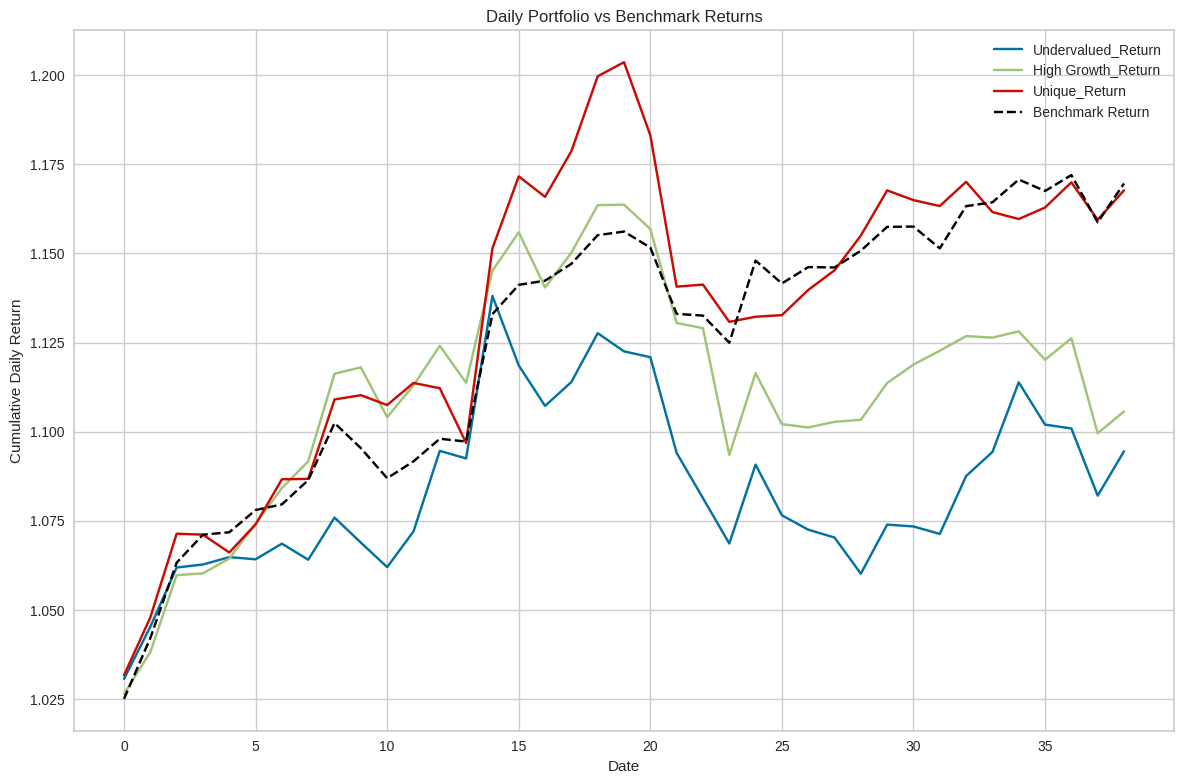

In [77]:
performance(test_data, test_data['spx'], ['Undervalued','High Growth', 'Unique'])

# Conclusion

This proof-of-concept shows how a lightweight K-Means pipeline can slice 21 raw fundamentals into intuitive buckets — Undervalued, High Growth, Prime Quality — so you jump straight to a targeted stock list instead of drowning in ratios. The seven-week smoke test confirms the labels behave differently in live markets, but it’s only a demo; broader data, multi-year walk-forwards, robust ranking methodology ,stress tests against random portfolios, Edge cases — outliers, and factor regressions are still on the to-do list.

Next up : A Streamlit front-end so you can run the screener in your browser, LLM layer that turns plain-language requests — “Show me cheap stocks” — into actionable query, and a fully robust back-testing suite.